## Initializations

Data from: https://www.kaggle.com/mansoordaku/ckdisease

In [2]:
# ### Basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
import random

# ### Statistics
import scipy.stats as sc_stats

# ### Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# ### Methods for classification 
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, cohen_kappa_score 

# ### Model selection
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

# ### Methods for regression
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# ### For feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

warnings.filterwarnings('ignore')

import utils as ute

### Parameters

In [3]:
pvalue_th = 0.05
seed_th = 0

### Functions 

In [4]:
def check_end_or_begin_with(list_strings, word, mode="end"):
    correct_result = list()
    for f in list_strings:
        if mode == "end" and f.endswith(word):
            correct_result.append(f)
        elif mode == "start" and f.startswith(word):
            correct_result.append(f)
        else:
            if mode != "end" and mode != "start":
                print("Choose between end or start mode")
    return correct_result

def auc_scorer(clf, X, y, model): 
    
    fpr, tpr, _ = roc_curve( y, clf.decision_function(X) ) 
        
    roc_auc = auc(fpr, tpr)

    plt.figure()    # Plot the ROC curve
    plt.plot(fpr, tpr, 
             label='ROC curve from '+model+' model (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    plt.show()

    return fpr,tpr,roc_auc


## Data and Exploratory Data Analysis

The data that we are going to use has 26 different features. It has also 400 samples. 
Each sample is a registered patient. All features are explained:

age -> Age of the patient. Numerical feature.

bp -> Blood pressure. Numerical feature.

sg -> Specific gravity. Numerical feature.

al -> Albumin. Numerical feature.

su -> Sugar in blood. Numerical feature.

rbc -> Red blood cells. Cathegorical feature. Levels = "normal", "abnormal".

pc -> Pus cell. Cathegorical feature. Levels = "normal", "abnormal".

pcc -> Pus cell clumps. Cathegorical feature. Levels = "present", "notpresent".

ba -> Bacteria. Cathegorical feature. Levels = "present", "notpresent".

bgr -> Blood glucose random. Numerical feature.

bu -> Blood urea. Numerical feature.

sc -> Serum creatinine. Numerical feature.

sod -> Sodium. Numerical feature.

pot -> Potassium. Numerical feature.

hemo -> Hemoglobin. Numerical feature.

pcv -> Packed cell volume. Numerical feature.

wc -> White blood cell count. Numerical feature.

rc -> Red blood cell count. Numerical feature.

htn -> Hypertension. Cathegorical feature. Levels = "yes", "no".

dm -> Diabetes mellitus. Cathegorical feature. Levels = "yes", "no".

cad -> Coronary artery disease. Cathegorical feature. Levels = "yes", "no".

appet -> Appetite. Cathegorical feature. Levels = "good", "poor".

pe -> Pedal edema. Cathegorical feature. Levels = "yes", "no".

ane -> Anemia. Cathegorical feature. Levels = "yes", "no".

classification -> Target variable to classify. 

In [5]:
df = pd.read_csv('Data/kidney_disease.csv')

print( "Columns name", df.columns.values )

print("Number of columns", df.shape[1])
print("Number of patients", df.shape[0])
print( "Data frame shape", df.shape )

Columns name ['id' 'age' 'bp' 'sg' 'al' 'su' 'rbc' 'pc' 'pcc' 'ba' 'bgr' 'bu' 'sc'
 'sod' 'pot' 'hemo' 'pcv' 'wc' 'rc' 'htn' 'dm' 'cad' 'appet' 'pe' 'ane'
 'classification']
Number of columns 26
Number of patients 400
Data frame shape (400, 26)


In [6]:
type_var_dict = {col: df[col].dtype.name for col in df.columns}
    
print("Table of variables type")
var_type_df = pd.DataFrame(type_var_dict, index=[0])
print( var_type_df )

print("Number of variable of type int64", np.sum(var_type_df.T == "int64"))
print("Number of variable of type float64", np.sum(var_type_df.T == "float64"))
print("Number of variable of type object", np.sum(var_type_df.T == "object"))

Table of variables type
      id      age       bp       sg       al       su     rbc      pc     pcc  \
0  int64  float64  float64  float64  float64  float64  object  object  object   

       ba  ...     pcv      wc      rc     htn      dm     cad   appet  \
0  object  ...  object  object  object  object  object  object  object   

       pe     ane classification  
0  object  object         object  

[1 rows x 26 columns]
Number of variable of type int64 0    1
dtype: int64
Number of variable of type float64 0    11
dtype: int64
Number of variable of type object 0    14
dtype: int64


## Data cleaning 

In [7]:
problem_columns = ["pcv", "wc", "rc", "dm", "cad", "classification"]
characters = ["\t"]
for col in problem_columns:
    new_colum_list = []
    for val in df[col].values:
        try:    
            if "\t?" in val:
                new_colum_list.append( np.nan )

            elif "\t" in val:
                x = re.sub("\t", "")
                new_colum_list.append( x )

            else:
                new_colum_list.append( val )
        except:
            new_colum_list.append( np.nan )
            
    df[col] = new_colum_list

columns_numeric = ["pcv", "wc", "rc"]
for col in columns_numeric:
    df[col] = pd.to_numeric( df[col] )

### Categoric

In [8]:
features_to_bin = [
    'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'
]

features_created = []
for col in features_to_bin:
    
    col_to_nan = col + "_nan"
    df[col_to_nan] = df[col].isna()*1
    features_created.append(col_to_nan)
    
    first_cat = df[col].dropna().unique()[0]
    col_to_cat_bin = col + "_" + first_cat
    df[col_to_cat_bin] = (df[col] == first_cat)*1
    features_created.append(col_to_cat_bin)

In [9]:
categorical_features = ['al', 'su'] + features_created

numerical_features = [
    'age', 'bp', 'sg', "bgr", 'pcv', 'wc', 'rc', 'bu', 'sc', 'sod', 'pot', 'hemo'
]

all_features = categorical_features + numerical_features

## Statistics 

In [10]:
for col in categorical_features:
    print(col, {str(uniq): np.round(100 * np.mean(df[col]==uniq), 2) for uniq in df[col].unique()})

al {'1.0': 11.0, '4.0': 6.0, '2.0': 10.75, '3.0': 10.75, '0.0': 49.75, 'nan': 0.0, '5.0': 0.25}
su {'0.0': 72.5, '3.0': 3.5, '4.0': 3.25, '1.0': 3.25, 'nan': 0.0, '2.0': 4.5, '5.0': 0.75}
rbc_nan {'1': 38.0, '0': 62.0}
rbc_normal {'0': 49.75, '1': 50.25}
pc_nan {'0': 83.75, '1': 16.25}
pc_normal {'1': 64.75, '0': 35.25}
pcc_nan {'0': 99.0, '1': 1.0}
pcc_notpresent {'1': 88.5, '0': 11.5}
ba_nan {'0': 99.0, '1': 1.0}
ba_notpresent {'1': 93.5, '0': 6.5}
htn_nan {'0': 99.5, '1': 0.5}
htn_yes {'1': 36.75, '0': 63.25}
dm_nan {'0': 98.25, '1': 1.75}
dm_yes {'1': 33.5, '0': 66.5}
cad_nan {'0': 99.0, '1': 1.0}
cad_no {'1': 90.5, '0': 9.5}
appet_nan {'0': 99.75, '1': 0.25}
appet_good {'1': 79.25, '0': 20.75}
pe_nan {'0': 99.75, '1': 0.25}
pe_no {'1': 80.75, '0': 19.25}
ane_nan {'0': 99.75, '1': 0.25}
ane_no {'1': 84.75, '0': 15.25}


In [11]:
features_to_drop = [
    "pcc_nan", "ba_nan", "htn_nan", "cad_nan", "pe_nan", "ane_nan"
]

df = df.drop(features_to_drop, axis=1)

In [12]:
print("Shape of the data", df.shape)

Shape of the data (400, 40)


### Numerical features

In [13]:
100 * np.mean(df[numerical_features].isna())

age      2.25
bp       3.00
sg      11.75
bgr     11.00
pcv     18.00
wc      27.00
rc      32.75
bu       4.75
sc       4.25
sod     21.75
pot     22.00
hemo    13.00
dtype: float64

### Numerical distributions

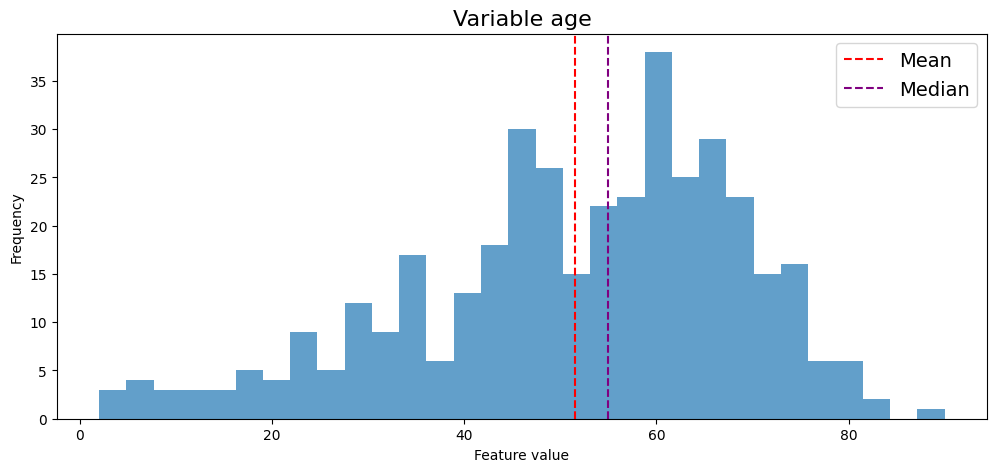

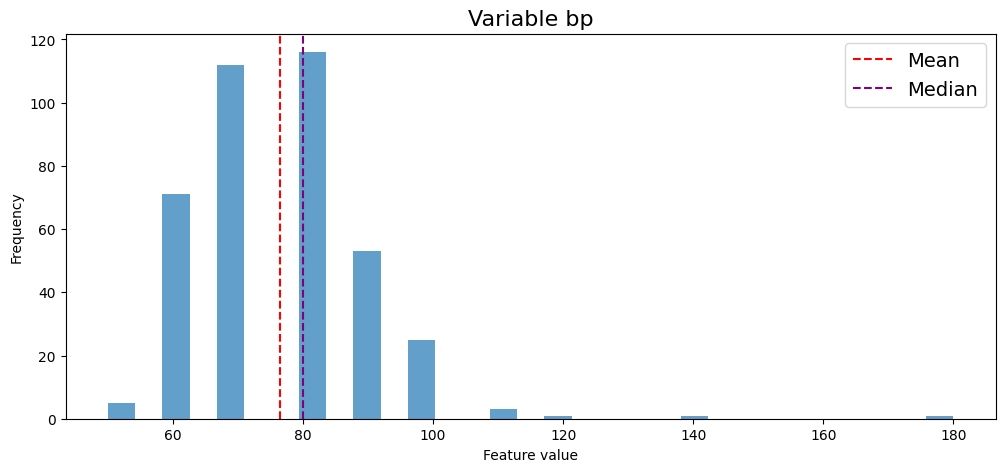

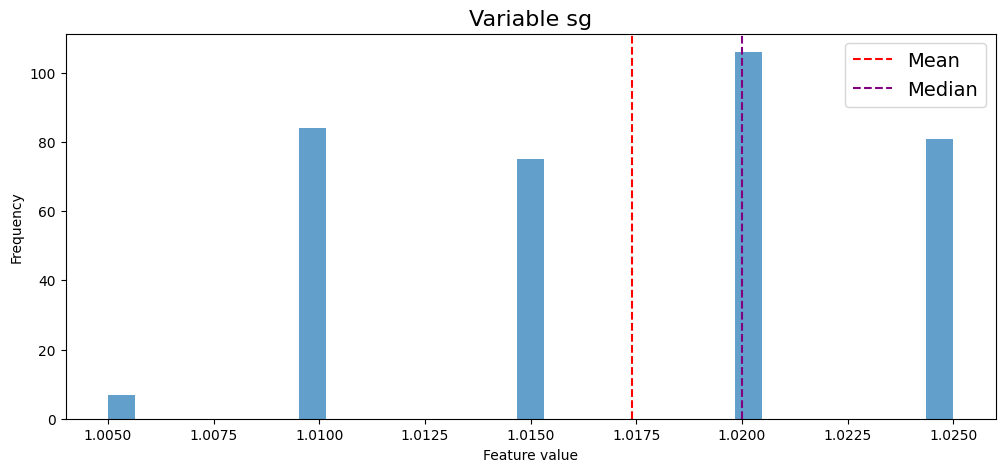

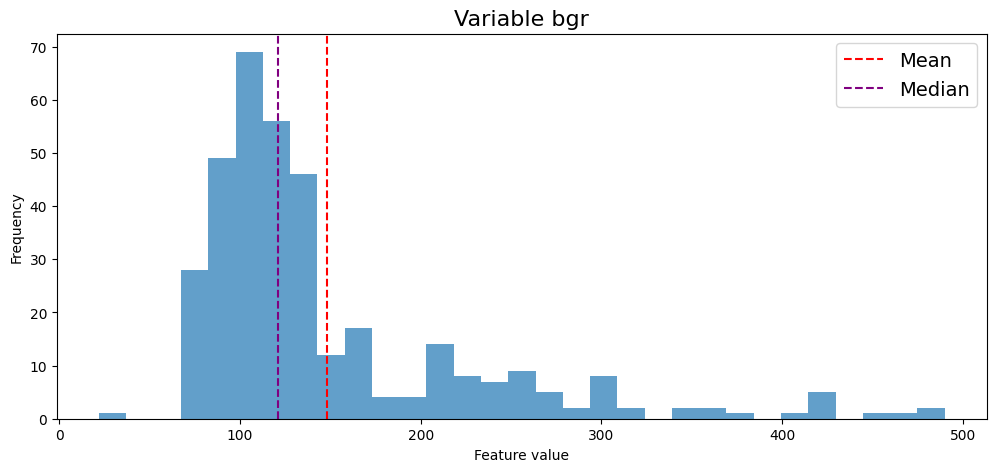

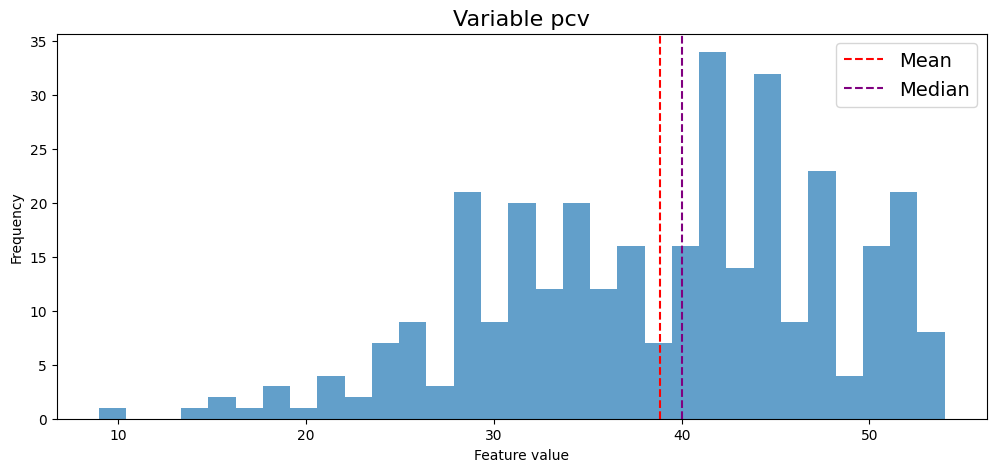

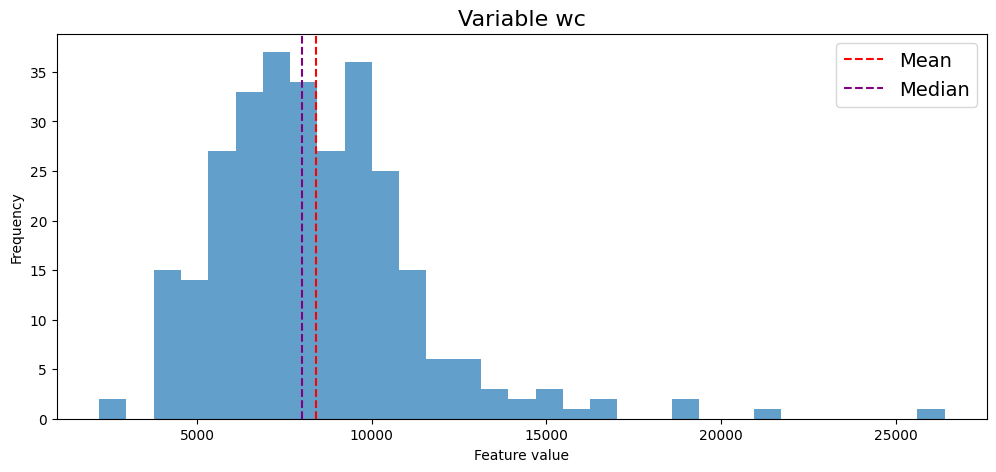

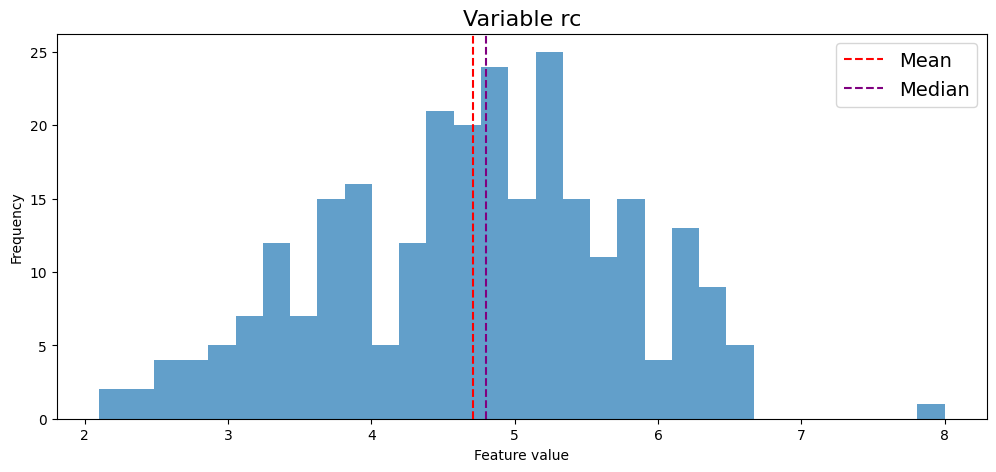

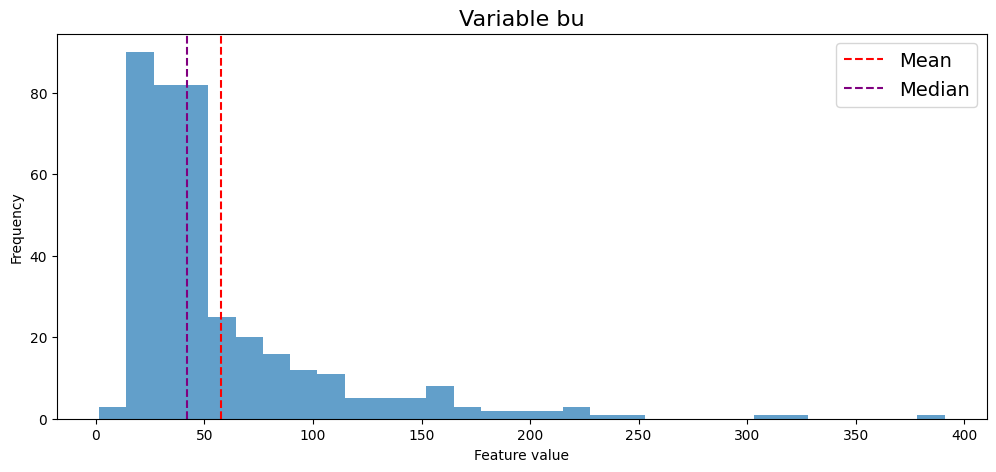

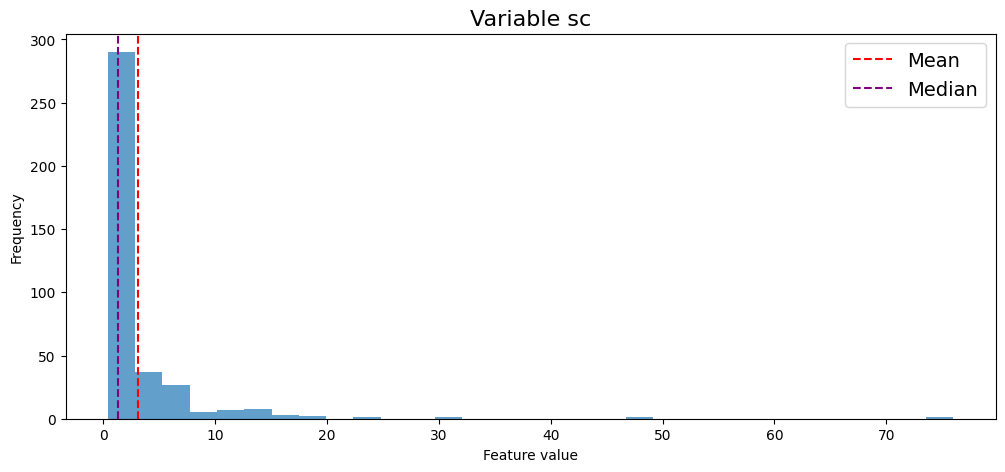

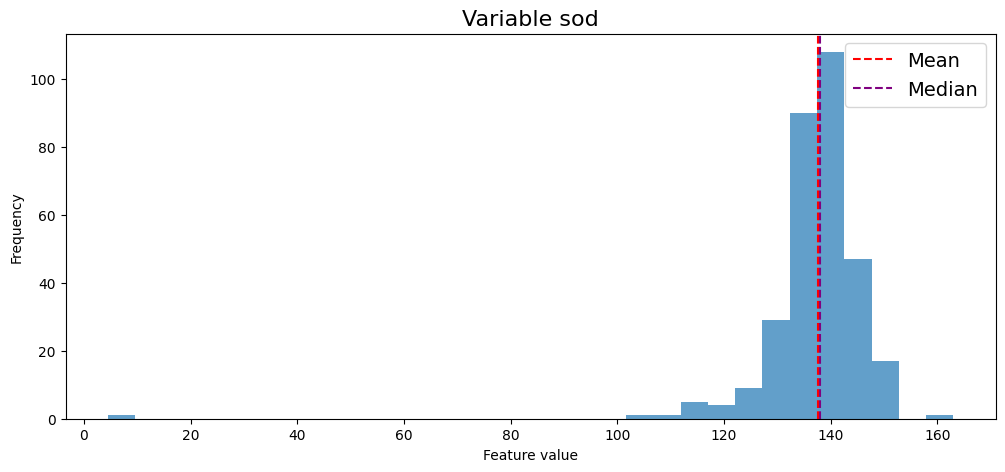

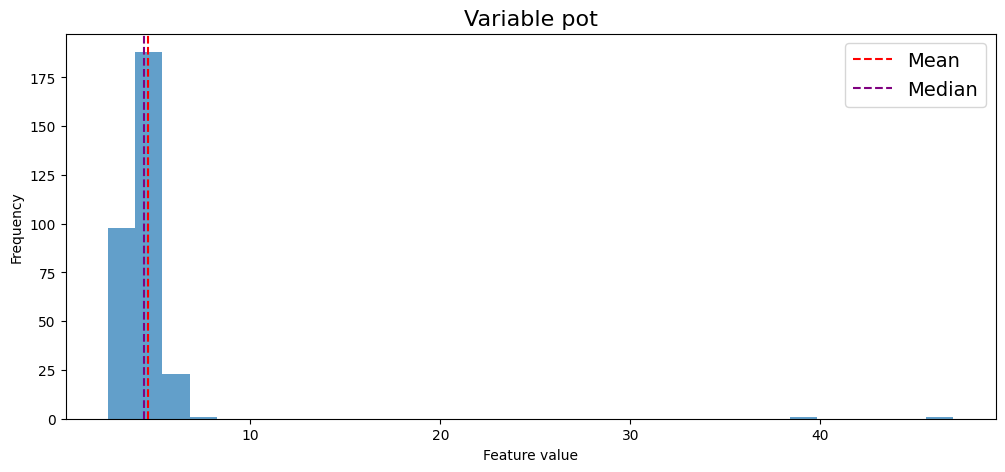

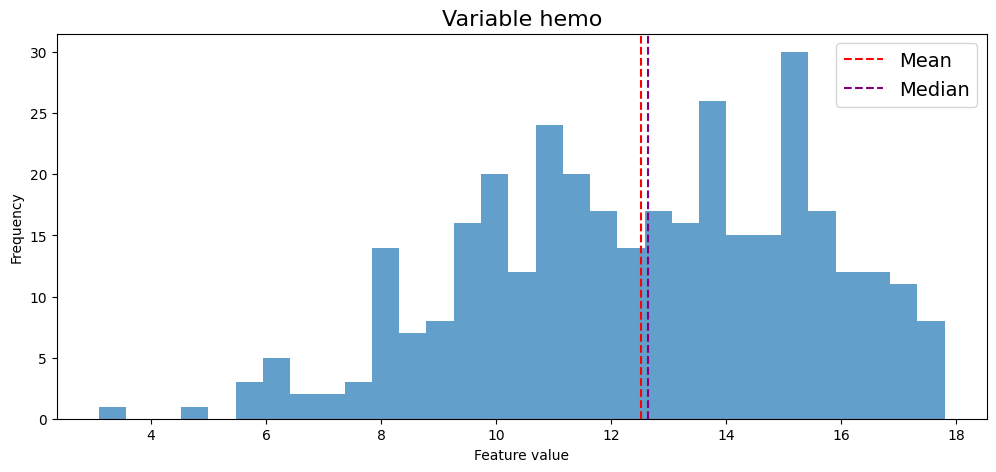

In [14]:
stats_num_list = []
for col in numerical_features:
        
    plt.figure(figsize=(12, 5))

    plt.hist( df[col], bins=31, alpha=0.7 )
    plt.title("Variable "+col, fontsize=16)

    plt.axvline( np.nanmean(df[col]), color="red", linestyle="--",label="Mean" )
    plt.axvline( np.nanmedian(df[col]), color="purple", linestyle="--",label="Median" )

    plt.ylabel("Frequency")
    plt.xlabel("Feature value")

    plt.legend(fontsize=14)

    plt.savefig("Images/Distribution_"+col+".png")

    stats_dict = obtain_stats( df[col].values )

    k, pvalue = sc_stats.normaltest( df[col].dropna().values )
    normal_distr = "Normal" if pvalue > pvalue_th else "Not-Normal"

    stats_num_list.append({
        "col": col,
        "statistic": k,
        "normal_distr": normal_distr,
        "pvalue_normal": pvalue,
        "pvalue_normal_str": ute.get_p_string(pvalue),
        "n_nans": np.sum(np.isnan(df[col].values)),
        "perc_nans": 100 * np.sum(np.isnan(df[col].values))/df.shape[0],
        "min": stats_dict["min"],
        "perct25": stats_dict["perct25"],
        "mean": stats_dict["mean"],
        "median": stats_dict["median"],
        "std": stats_dict["std"],
        "perct75": stats_dict["perct75"],
        "max": stats_dict["max"],
    })
        
stats_num_df = pd.DataFrame(stats_num_list)

In [15]:
stats_num_df

,col,statistic,normal_distr,pvalue_normal,pvalue_normal_str,n_nans,perc_nans,min,perct25,mean,median,std,perct75,max
0,age,25.308087,Not-Normal,3.194617e-06,***,9,2.25,2.000,42.00,51.483376,55.00,17.147744,64.50,90.000
1,bp,165.604015,Not-Normal,1.095330e-36,***,12,3.00,50.000,70.00,76.469072,80.00,13.665993,80.00,180.000
2,sg,145.436230,Not-Normal,2.623758e-32,***,47,11.75,1.005,1.01,1.017408,1.02,0.005709,1.02,1.025
3,bgr,152.594863,Not-Normal,7.318911e-34,***,44,11.00,22.000,99.00,148.036517,121.00,79.170285,163.00,490.000
4,pcv,11.492661,Not-Normal,3.194481e-03,**,72,18.00,9.000,32.00,38.871951,40.00,8.987224,45.00,54.000
5,wc,117.060021,Not-Normal,3.808373e-26,***,108,27.00,2200.000,6500.00,8413.698630,8000.00,2946.675167,9800.00,26400.000
6,rc,2.429437,Normal,2.967936e-01,-,131,32.75,2.100,3.90,4.707435,4.80,1.023416,5.40,8.000
7,bu,235.627959,Not-Normal,6.823997e-52,***,19,4.75,1.500,27.00,57.425722,42.00,50.436685,66.00,391.000
8,sc,558.648180,Not-Normal,4.910084e-122,***,17,4.25,0.400,0.90,3.072454,1.30,5.733626,2.80,76.000
9,sod,453.506037,Not-Normal,3.329779e-99,***,87,21.75,4.500,135.00,137.528754,138.00,10.392111,142.00,163.000


In [16]:
print( "Percentage of normal distributed values", 
      100*np.sum(stats_num_df["normal_distr"] == "Normal")/stats_num_df.shape[0], "%" )

Percentage of normal distributed values 8.333333333333334 %


### Statics and distributions

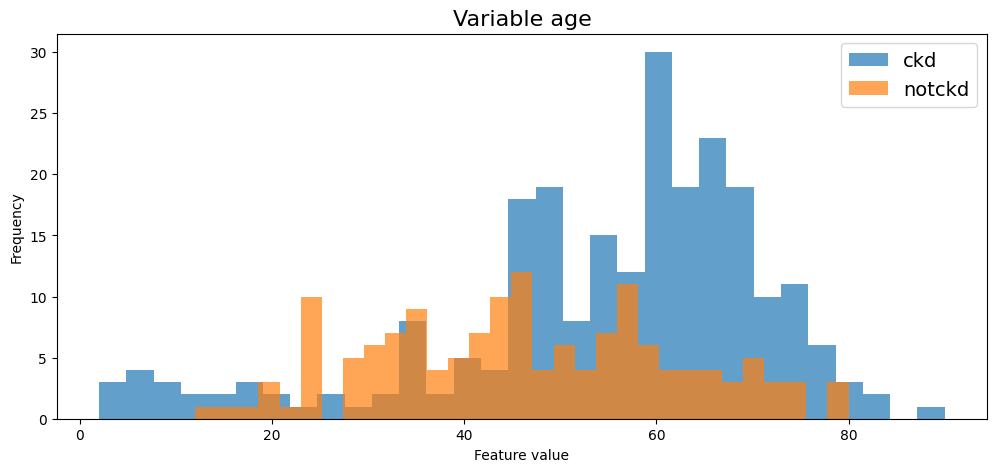

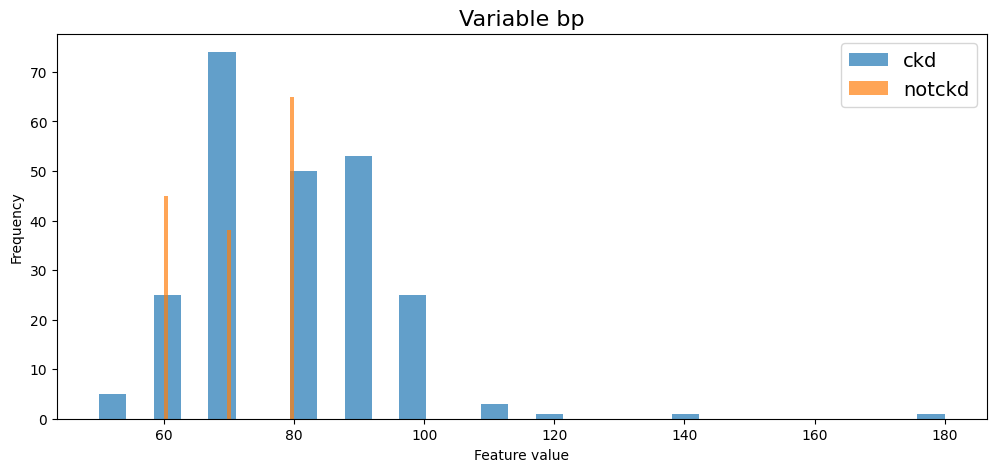

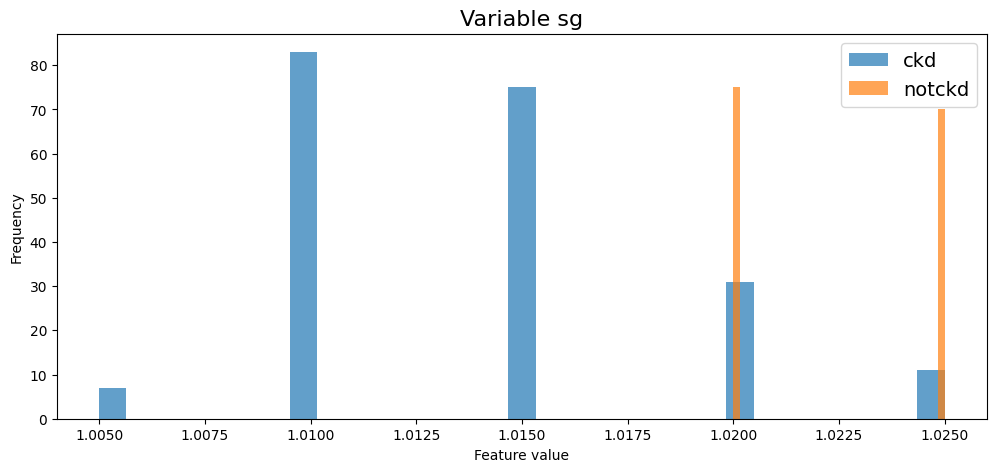

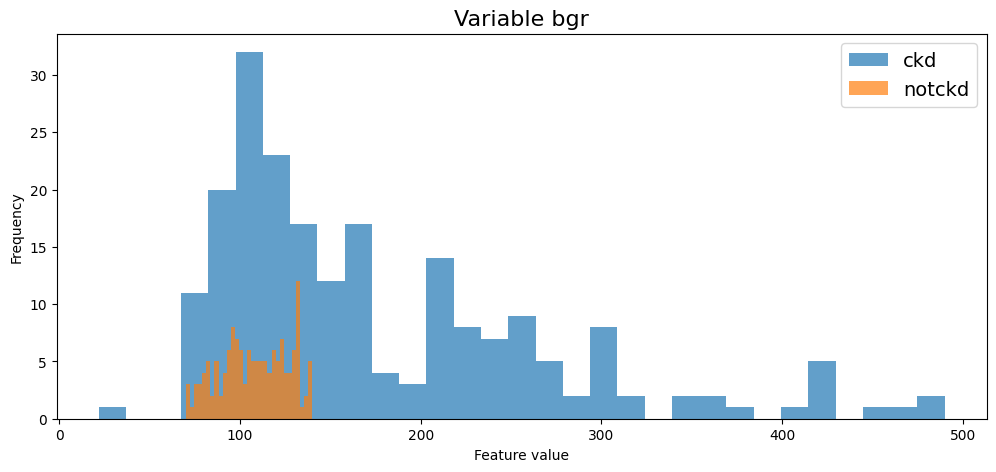

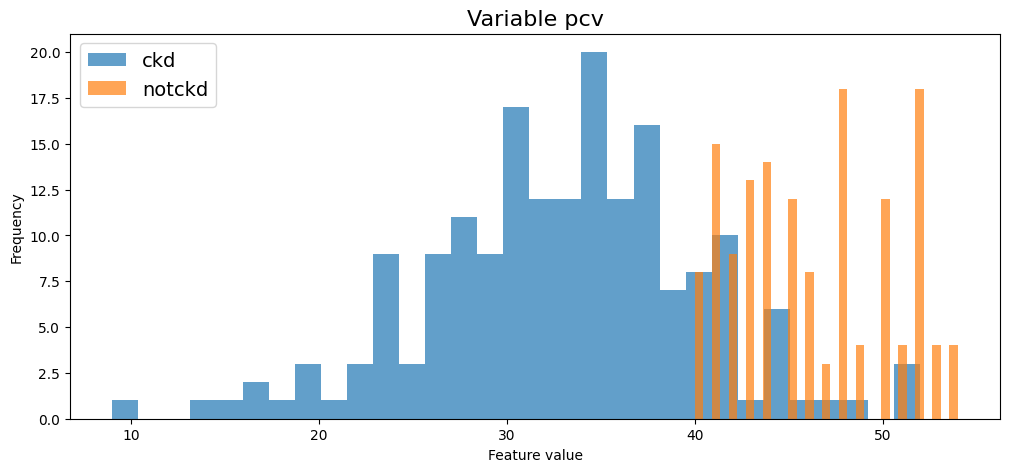

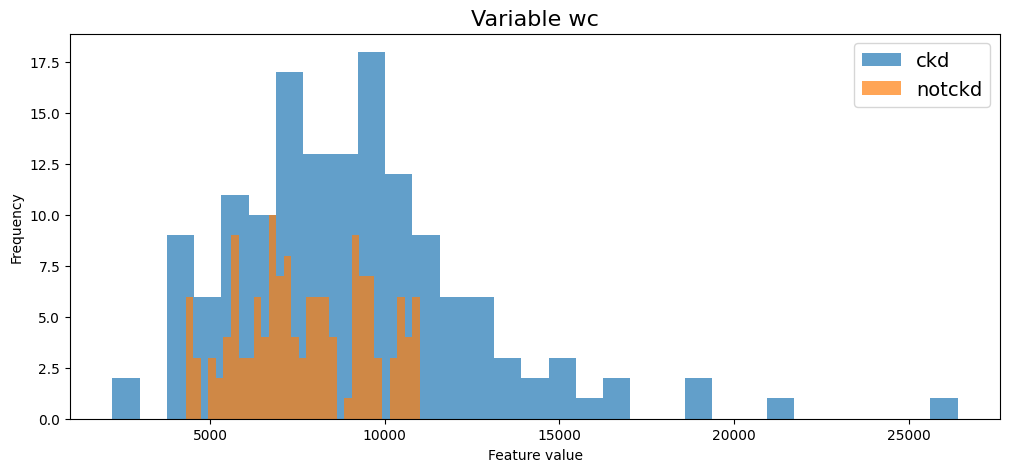

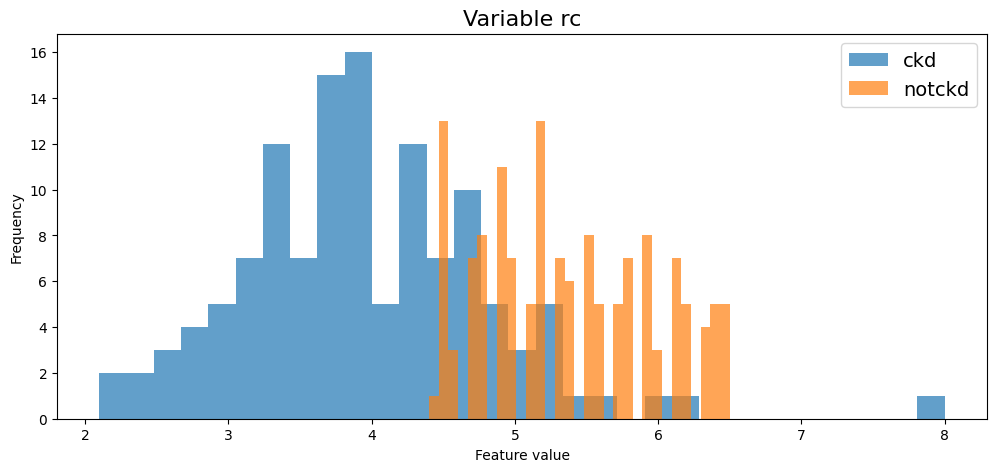

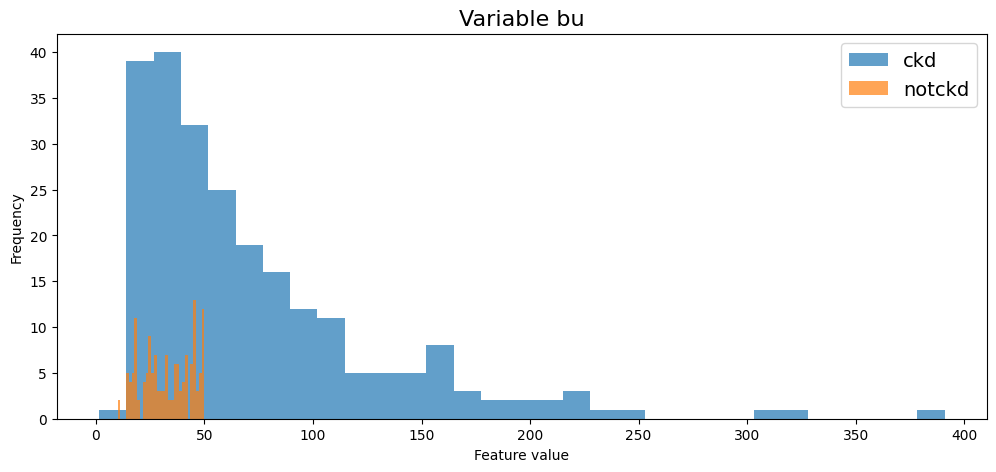

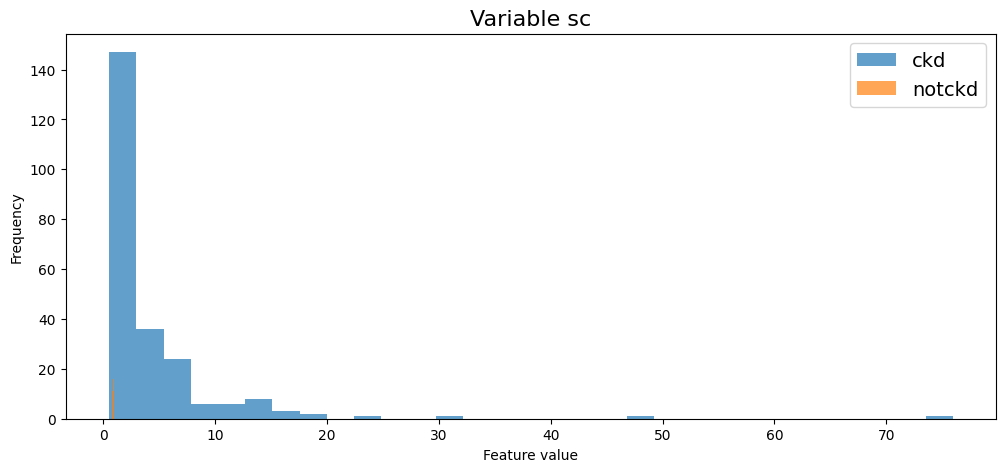

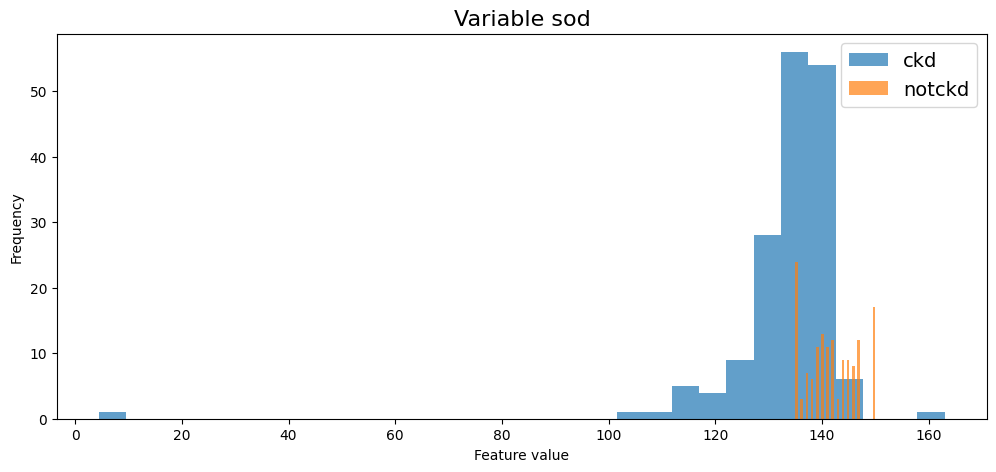

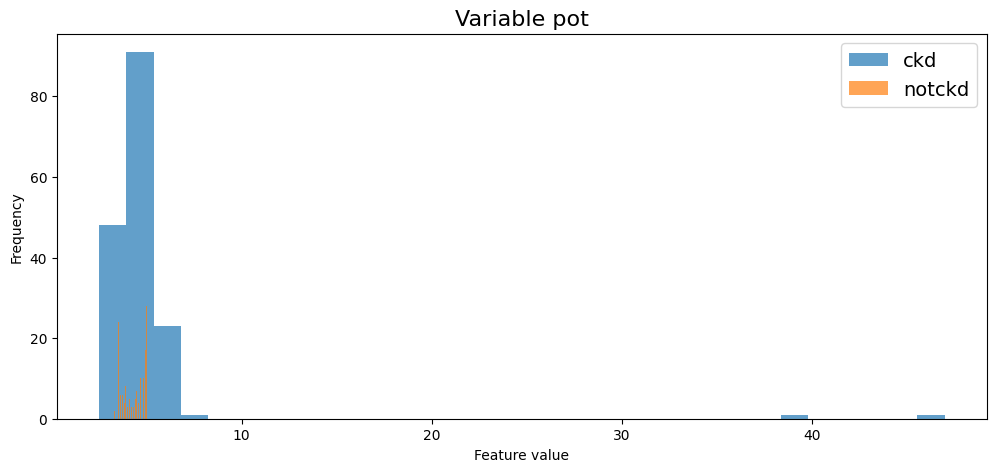

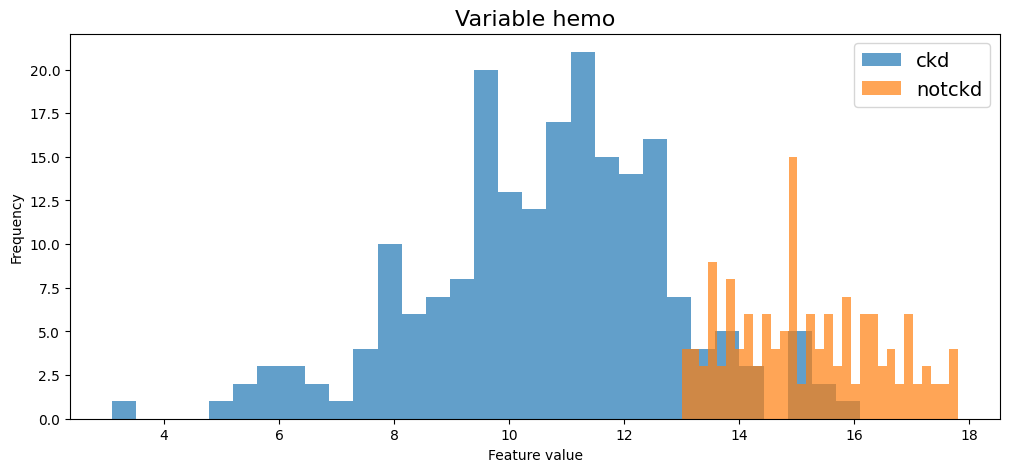

In [17]:
dict_clf = []
for i, col in enumerate(numerical_features):
    
    val_x = df[df["classification"] == "ckd"][col].dropna().values
    val_y = df[df["classification"] == "notckd"][col].dropna().values
    stc, pvalue = sc_stats.mannwhitneyu(val_x, val_y)

    dict_clf.append({
        "Variable": col,
        "pvalue": pvalue,
        "pvalue_str": ute.get_p_string(pvalue),
    })
    
    plt.figure(figsize=(12, 5))
    
    plt.hist( val_x, label="ckd", alpha=0.7, bins=31 )
    plt.hist( val_y, label="notckd", alpha=0.7, bins=31 )
    plt.title("Variable "+col, fontsize=16)

    plt.ylabel("Frequency")
    plt.xlabel("Feature value")

    plt.legend(fontsize=14)

    plt.savefig("Images/TargetDistribution_"+col+".png")

In [18]:
pd.DataFrame(dict_clf)

,Variable,pvalue,pvalue_str
0,age,5.821575e-08,***
1,bp,1.184991e-08,***
2,sg,7.779333e-44,***
3,bgr,4.669938e-15,***
4,pcv,3.369137e-45,***
5,wc,6.127996e-04,***
6,rc,4.997798e-33,***
7,bu,1.296963e-16,***
8,sc,1.208438e-43,***
9,sod,1.642389e-20,***


### Correlation plot

In [19]:
corr_mat = np.zeros( (stats_num_df.shape[0], stats_num_df.shape[0]) )
pvalue_mat = np.zeros( (stats_num_df.shape[0], stats_num_df.shape[0]) )
star_mat = np.zeros( (stats_num_df.shape[0], stats_num_df.shape[0]),dtype=object )

for i, col_i in enumerate(numerical_features):
    for j, col_j in enumerate(numerical_features):
        idx_values = df[[col_i, col_j]].dropna().index.values
        
        col_i_values = df[col_i].iloc[idx_values].values
        col_j_values = df[col_j].iloc[idx_values].values
        
        corrp, pvalue = sc_stats.pearsonr(col_i_values, col_j_values)
        
        corr_mat[i,j] = corrp
        pvalue_mat[i,j] = pvalue
        star_mat[i,j] = ute.get_p_string(pvalue)

In [20]:
corr_df = pd.DataFrame(corr_mat)
corr_df.columns = stats_num_df["col"].values
corr_df.index = stats_num_df["col"].values
corr_df.style.background_gradient(cmap='coolwarm')

,age,bp,sg,bgr,pcv,wc,rc,bu,sc,sod,pot,hemo
age,1.000000,0.159480,-0.191096,0.244992,-0.243951,0.118341,-0.268896,0.196985,0.132531,-0.100046,0.058377,-0.192928
bp,0.159480,1.000000,-0.218836,0.160193,-0.326871,0.030705,-0.261936,0.188517,0.146222,-0.116422,0.075151,-0.306540
sg,-0.191096,-0.218836,1.000000,-0.374710,0.604604,-0.245442,0.579476,-0.314295,-0.361473,0.412190,-0.072787,0.602582
bgr,0.244992,0.160193,-0.374710,1.000000,-0.302003,0.149785,-0.281541,0.143322,0.114875,-0.267848,0.066966,-0.306189
pcv,-0.243951,-0.326871,0.604604,-0.302003,1.000000,-0.197304,0.791524,-0.607320,-0.403903,0.376914,-0.163182,0.895347
wc,0.118341,0.030705,-0.245442,0.149785,-0.197304,1.000000,-0.163506,0.055574,-0.003545,0.005645,-0.104641,-0.172149
rc,-0.268896,-0.261936,0.579476,-0.281541,0.791524,-0.163506,1.000000,-0.579087,-0.400852,0.344873,-0.158309,0.798880
bu,0.196985,0.188517,-0.314295,0.143322,-0.607320,0.055574,-0.579087,1.000000,0.586368,-0.323054,0.357049,-0.610360
sc,0.132531,0.146222,-0.361473,0.114875,-0.403903,-0.003545,-0.400852,0.586368,1.000000,-0.690158,0.326107,-0.401670
sod,-0.100046,-0.116422,0.412190,-0.267848,0.376914,0.005645,0.344873,-0.323054,-0.690158,1.000000,0.097887,0.365183


In [21]:
pvalue_df = pd.DataFrame(pvalue_mat)
pvalue_df.columns = stats_num_df["col"].values
pvalue_df.index = stats_num_df["col"].values
pvalue_df.style.background_gradient(cmap='coolwarm')

,age,bp,sg,bgr,pcv,wc,rc,bu,sc,sod,pot,hemo
age,0.000000,0.001843,0.000344,0.000004,0.000010,0.044789,0.000009,0.000131,0.010295,0.080086,0.308739,0.000339
bp,0.001843,0.000000,0.000044,0.002727,0.000000,0.605713,0.000017,0.000261,0.004658,0.042175,0.191296,0.000000
sg,0.000344,0.000044,0.000000,0.000000,0.000000,0.000041,0.000000,0.000000,0.000000,0.000000,0.228071,0.000000
bgr,0.000004,0.002727,0.000000,0.000000,0.000000,0.014476,0.000006,0.007157,0.031426,0.000003,0.250747,0.000000
pcv,0.000010,0.000000,0.000000,0.000000,0.000000,0.000846,0.000000,0.000000,0.000000,0.000000,0.007211,0.000000
wc,0.044789,0.605713,0.000041,0.014476,0.000846,0.000000,0.007537,0.354192,0.952652,0.929953,0.102968,0.003496
rc,0.000009,0.000017,0.000000,0.000006,0.000000,0.007537,0.000000,0.000000,0.000000,0.000000,0.014491,0.000000
bu,0.000131,0.000261,0.000000,0.007157,0.000000,0.354192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sc,0.010295,0.004658,0.000000,0.031426,0.000000,0.952652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sod,0.080086,0.042175,0.000000,0.000003,0.000000,0.929953,0.000000,0.000000,0.000000,0.000000,0.084306,0.000000


In [22]:
star_df = pd.DataFrame(star_mat)
star_df.columns = stats_num_df["col"].values
star_df.index = stats_num_df["col"].values

three_star_columns, two_star_columns, one_star_columns = [], [], []
for ct_i, col_i in enumerate(star_df.columns):
    for ct_j, col_j in enumerate(star_df.columns[(ct_i+1):]):
        if star_df[col_i].loc[col_j] == "***":
            three_star_columns.append(col_i+" + "+col_j)
        elif star_df[col_i].loc[col_j] == "**":
            two_star_columns.append(col_i+" + "+col_j)
        elif star_df[col_i].loc[col_j] == "*":
            one_star_columns.append(col_i+" + "+col_j)
        else:
            pass

display(star_df)

print("Columns with correlation p-value ***", three_star_columns)
print()
print("Columns with correlation p-value **", two_star_columns)
print()
print("Columns with correlation p-value *", one_star_columns)

,age,bp,sg,bgr,pcv,wc,rc,bu,sc,sod,pot,hemo
age,***,**,***,***,***,*,***,***,*,-,-,***
bp,**,***,***,**,***,-,***,***,**,*,-,***
sg,***,***,***,***,***,***,***,***,***,***,-,***
bgr,***,**,***,***,***,*,***,**,*,***,-,***
pcv,***,***,***,***,***,***,***,***,***,***,**,***
wc,*,-,***,*,***,***,**,-,-,-,-,**
rc,***,***,***,***,***,**,***,***,***,***,*,***
bu,***,***,***,**,***,-,***,***,***,***,***,***
sc,*,**,***,*,***,-,***,***,***,***,***,***
sod,-,*,***,***,***,-,***,***,***,***,-,***


Columns with correlation p-value *** ['age + sg', 'age + bgr', 'age + pcv', 'age + rc', 'age + bu', 'age + hemo', 'bp + sg', 'bp + pcv', 'bp + rc', 'bp + bu', 'bp + hemo', 'sg + bgr', 'sg + pcv', 'sg + wc', 'sg + rc', 'sg + bu', 'sg + sc', 'sg + sod', 'sg + hemo', 'bgr + pcv', 'bgr + rc', 'bgr + sod', 'bgr + hemo', 'pcv + wc', 'pcv + rc', 'pcv + bu', 'pcv + sc', 'pcv + sod', 'pcv + hemo', 'rc + bu', 'rc + sc', 'rc + sod', 'rc + hemo', 'bu + sc', 'bu + sod', 'bu + pot', 'bu + hemo', 'sc + sod', 'sc + pot', 'sc + hemo', 'sod + hemo']

Columns with correlation p-value ** ['age + bp', 'bp + bgr', 'bp + sc', 'bgr + bu', 'pcv + pot', 'wc + rc', 'wc + hemo']

Columns with correlation p-value * ['age + wc', 'age + sc', 'bp + sod', 'bgr + wc', 'bgr + sc', 'rc + pot', 'pot + hemo']


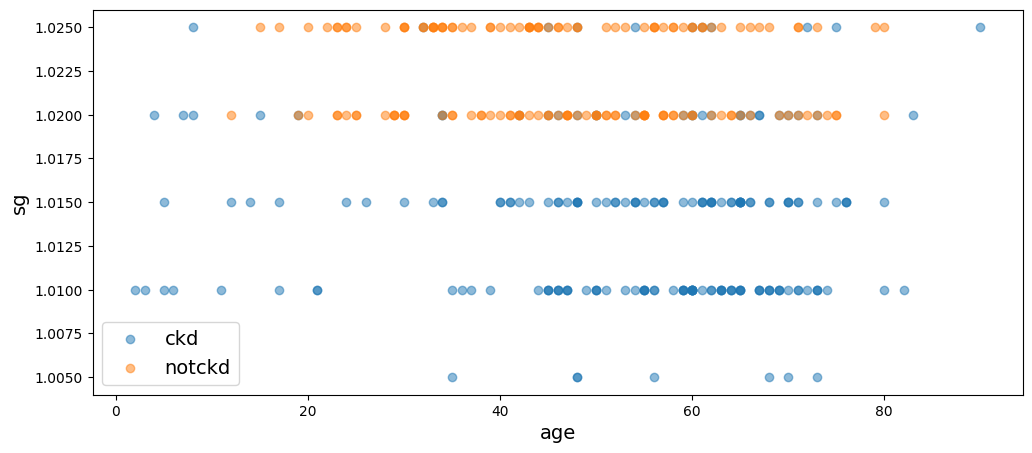

<Figure size 640x480 with 0 Axes>

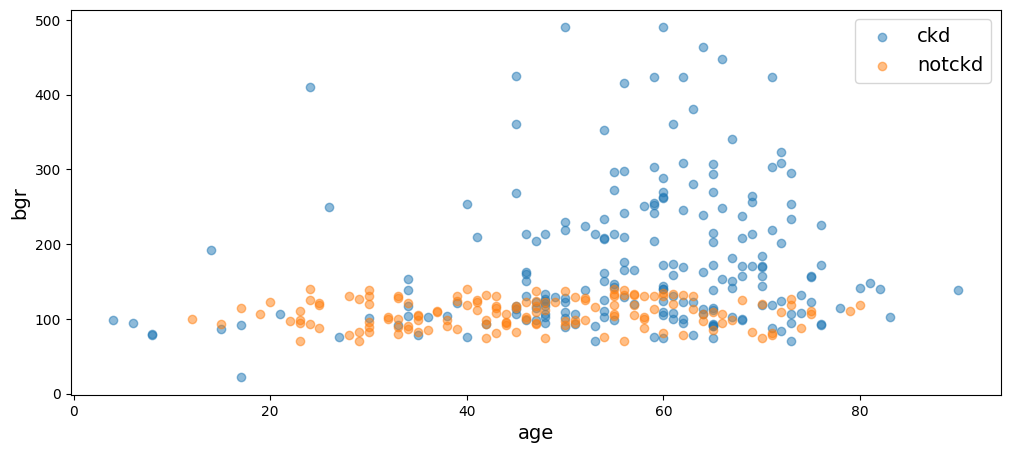

<Figure size 640x480 with 0 Axes>

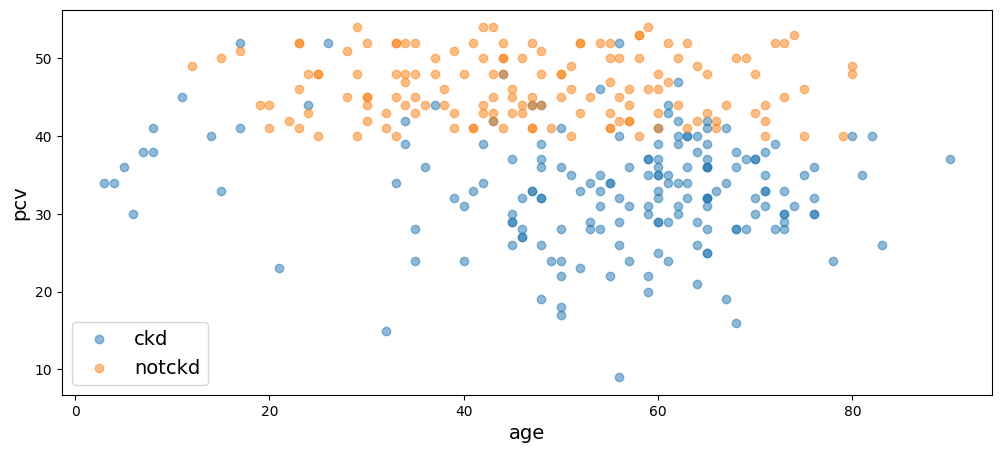

<Figure size 640x480 with 0 Axes>

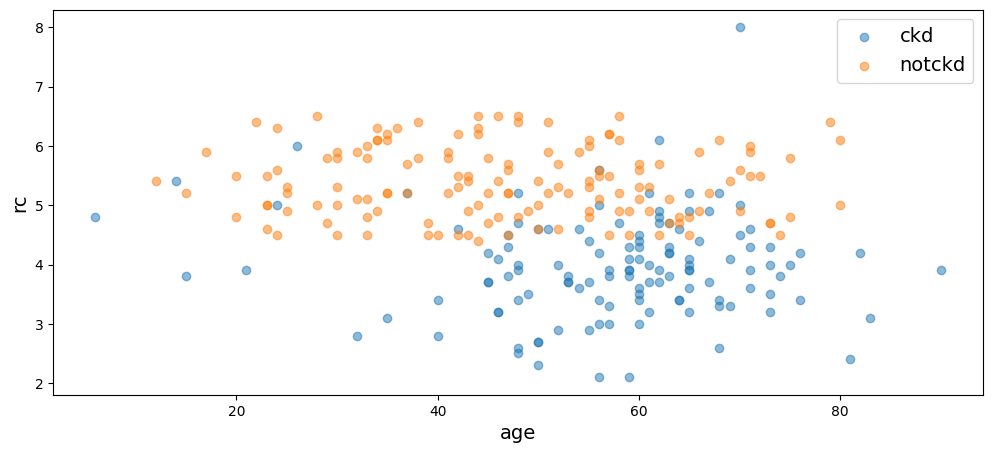

<Figure size 640x480 with 0 Axes>

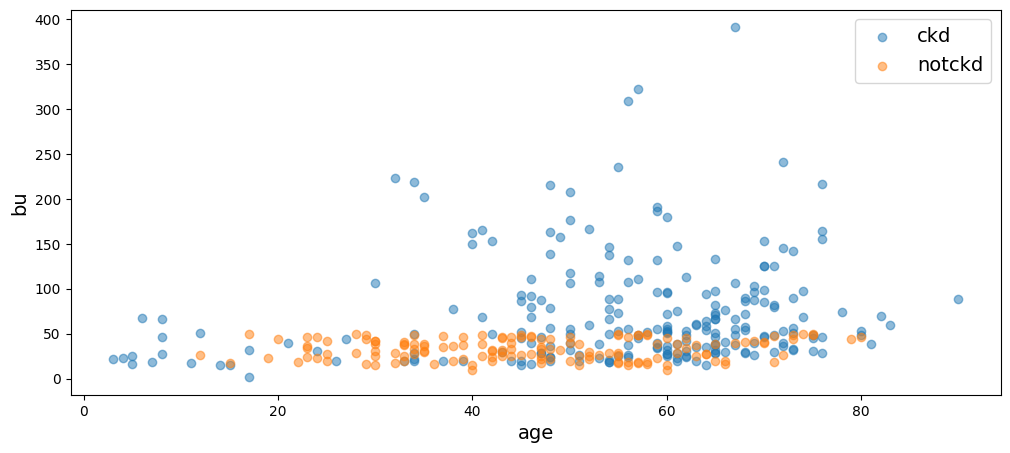

<Figure size 640x480 with 0 Axes>

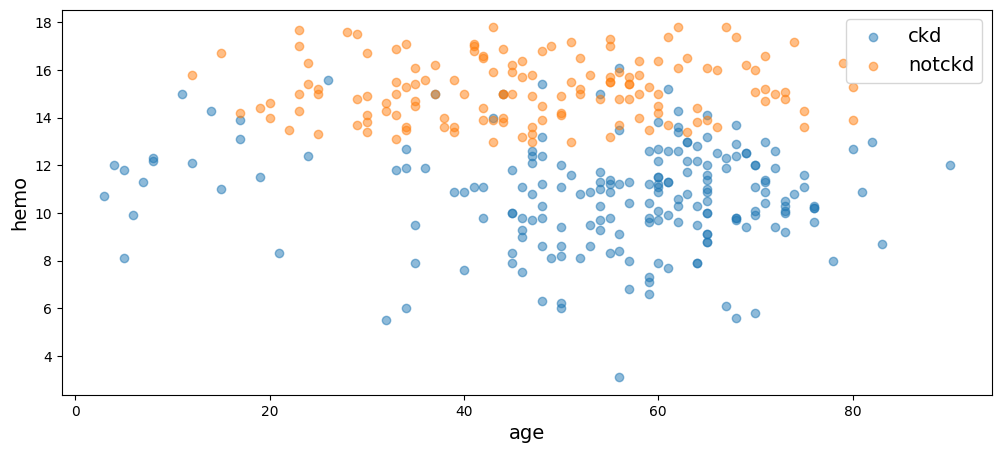

<Figure size 640x480 with 0 Axes>

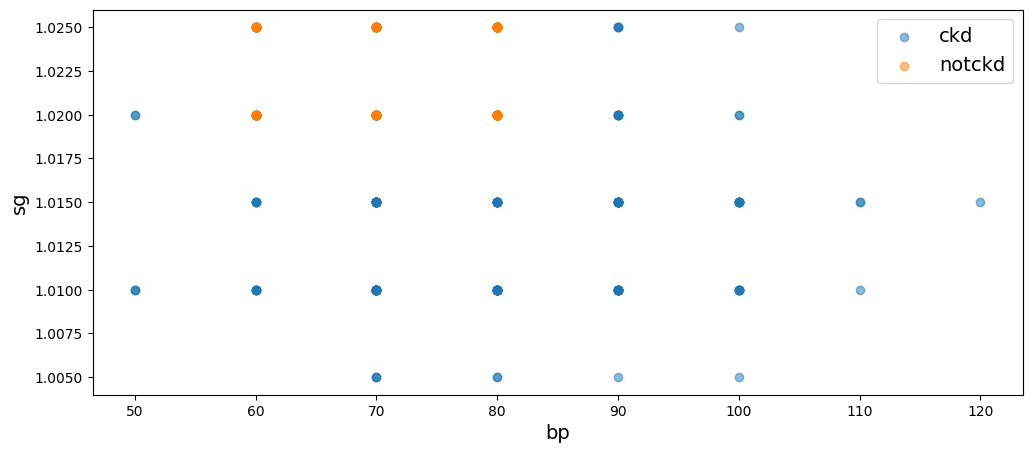

<Figure size 640x480 with 0 Axes>

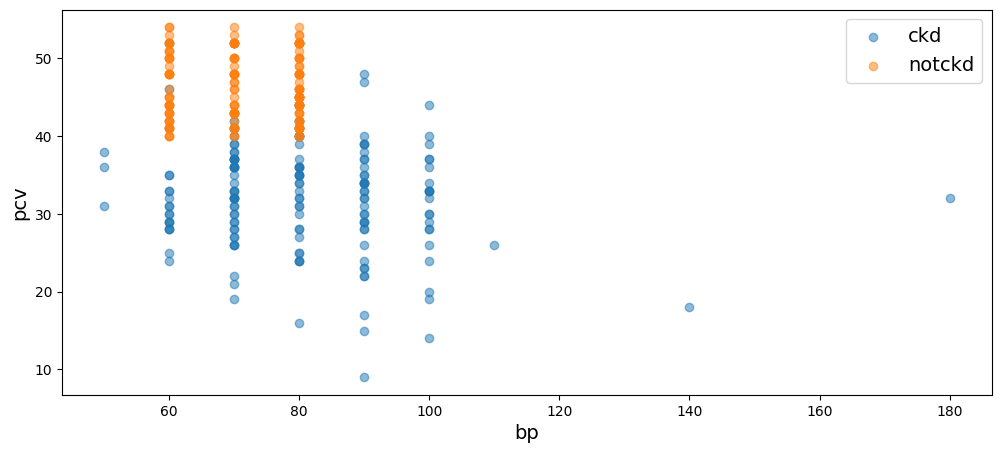

<Figure size 640x480 with 0 Axes>

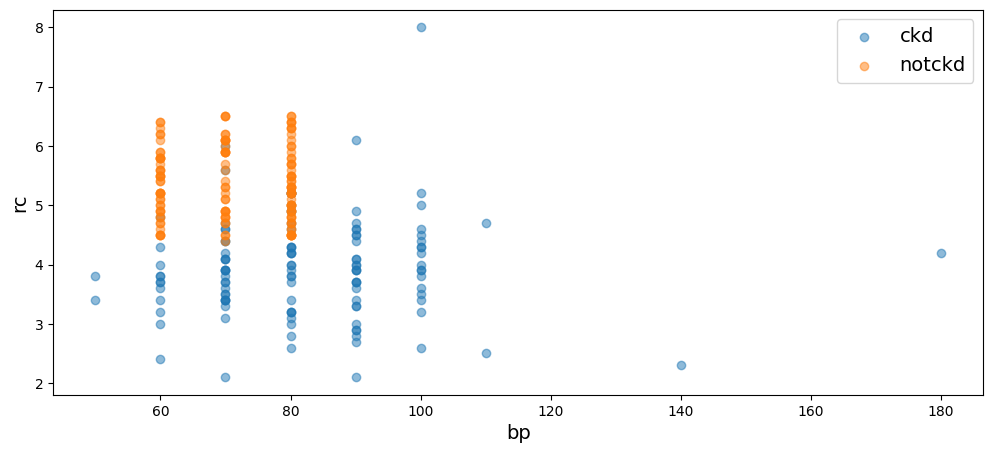

<Figure size 640x480 with 0 Axes>

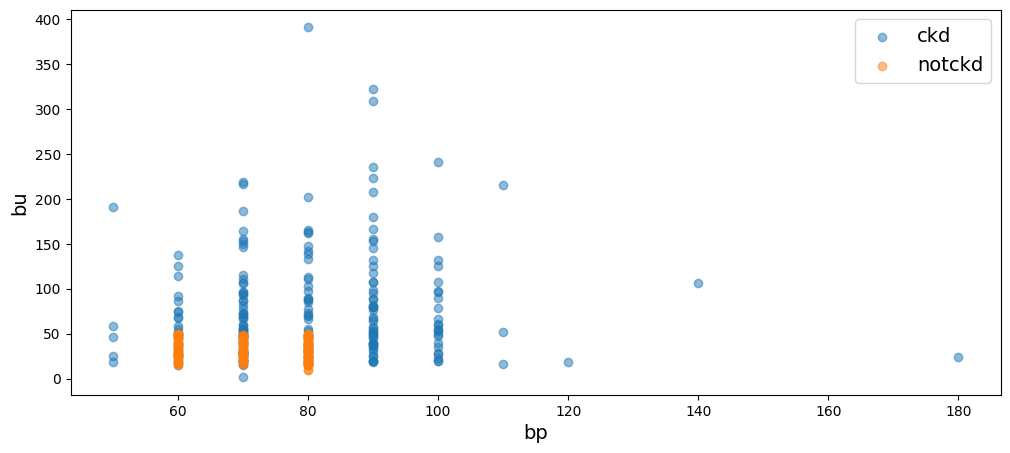

<Figure size 640x480 with 0 Axes>

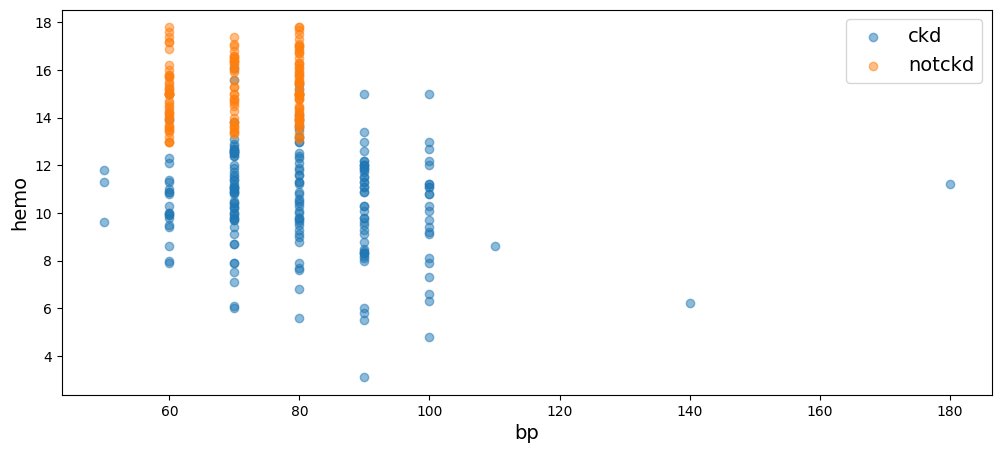

<Figure size 640x480 with 0 Axes>

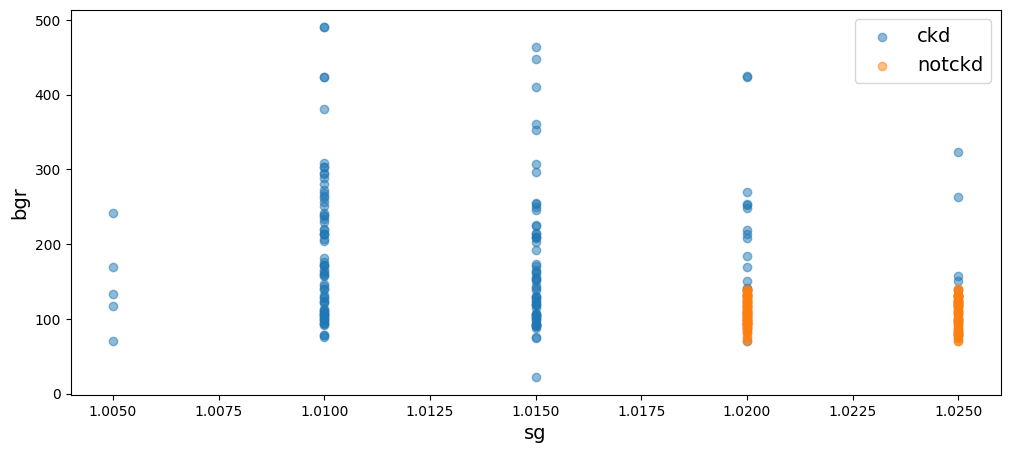

<Figure size 640x480 with 0 Axes>

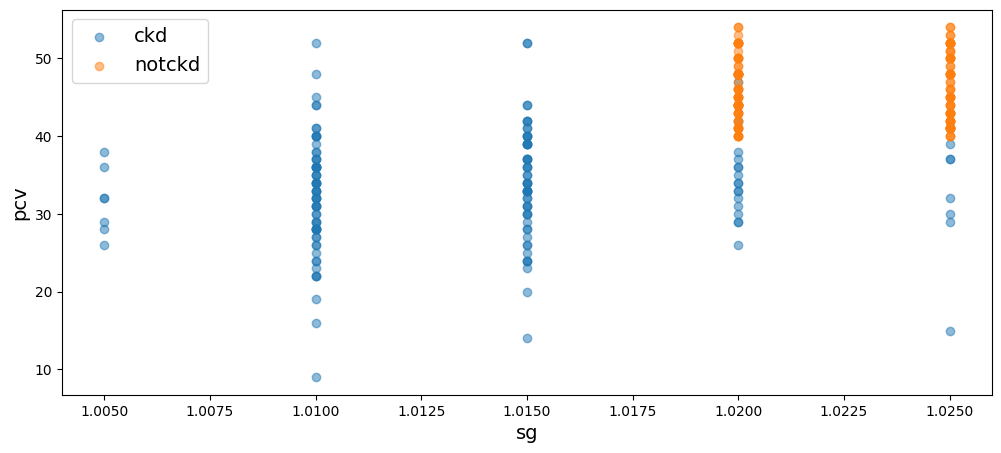

<Figure size 640x480 with 0 Axes>

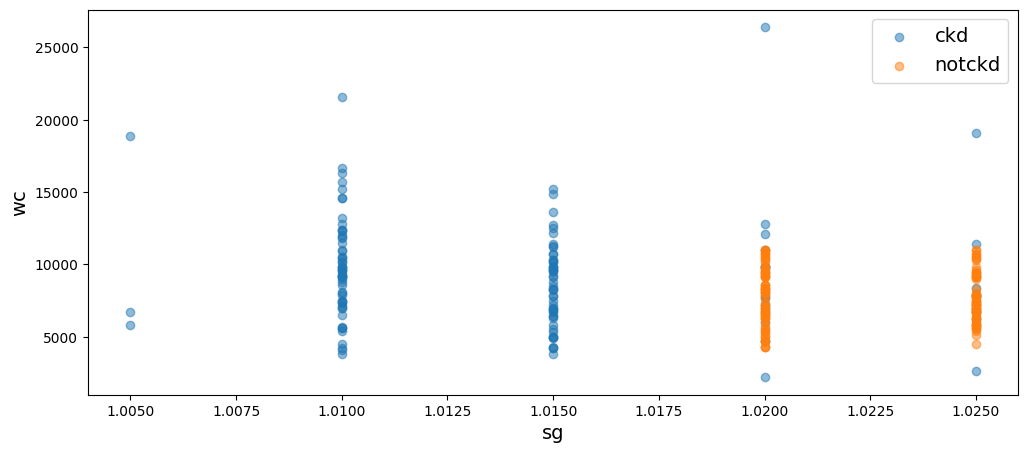

<Figure size 640x480 with 0 Axes>

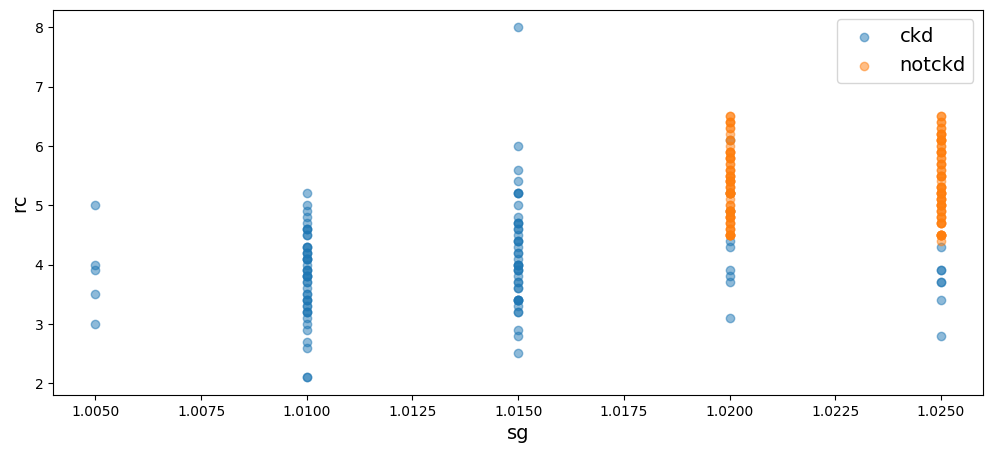

<Figure size 640x480 with 0 Axes>

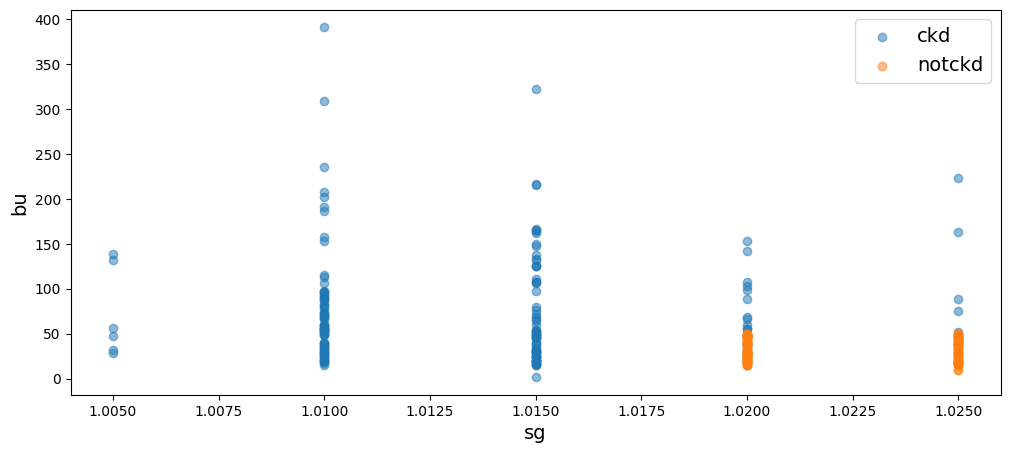

<Figure size 640x480 with 0 Axes>

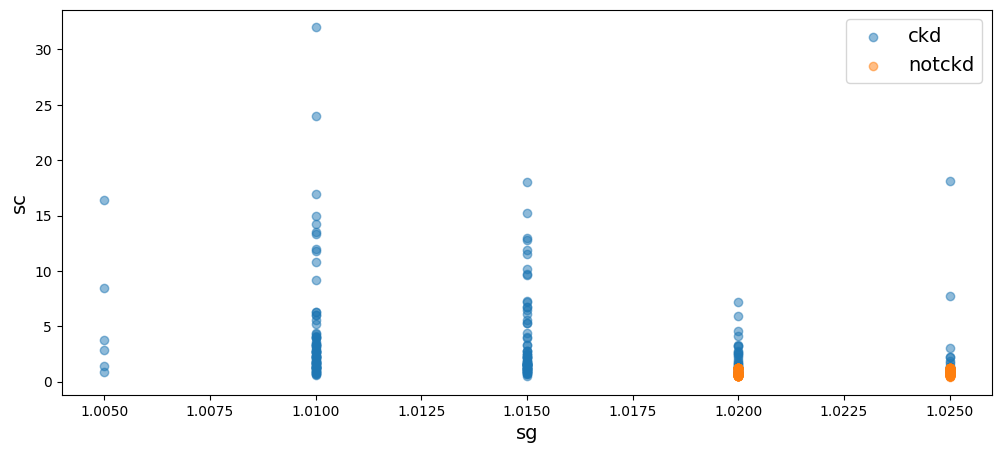

<Figure size 640x480 with 0 Axes>

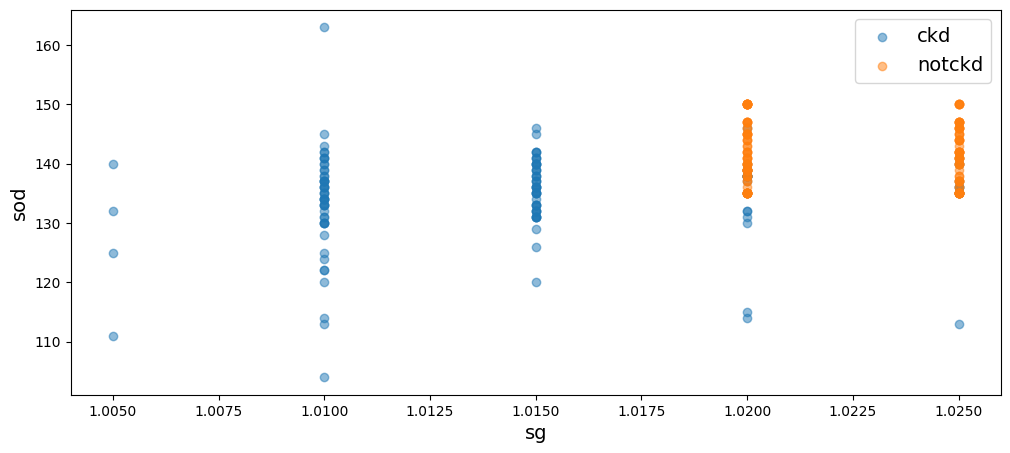

<Figure size 640x480 with 0 Axes>

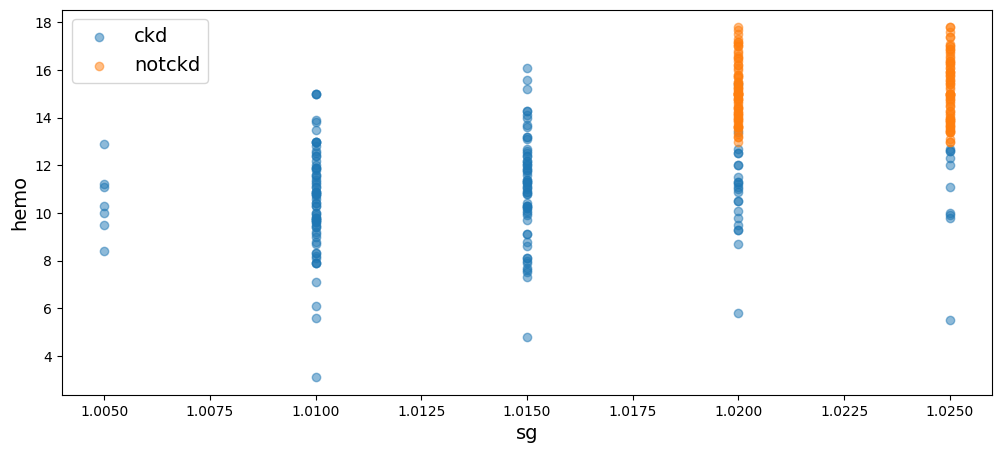

<Figure size 640x480 with 0 Axes>

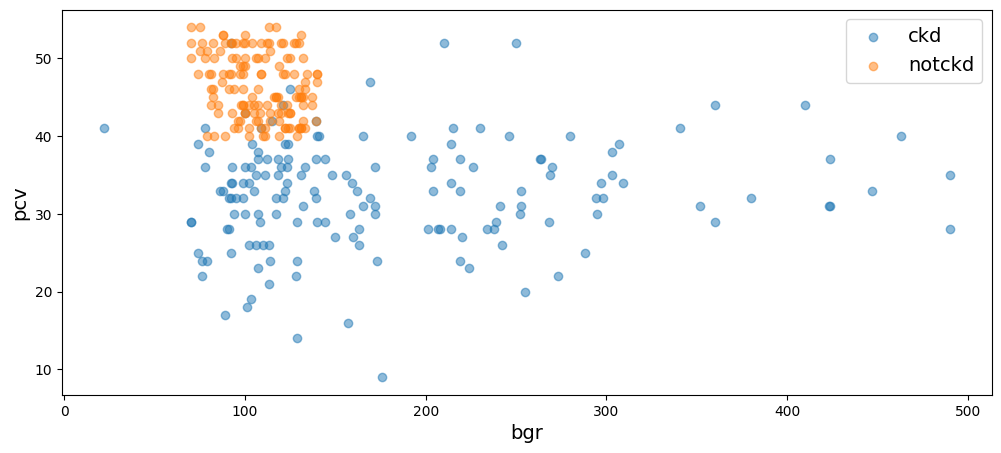

<Figure size 640x480 with 0 Axes>

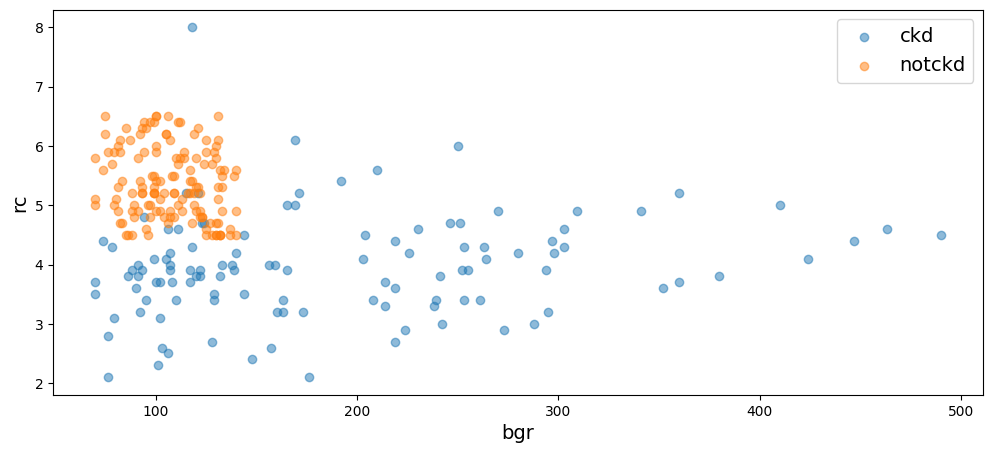

<Figure size 640x480 with 0 Axes>

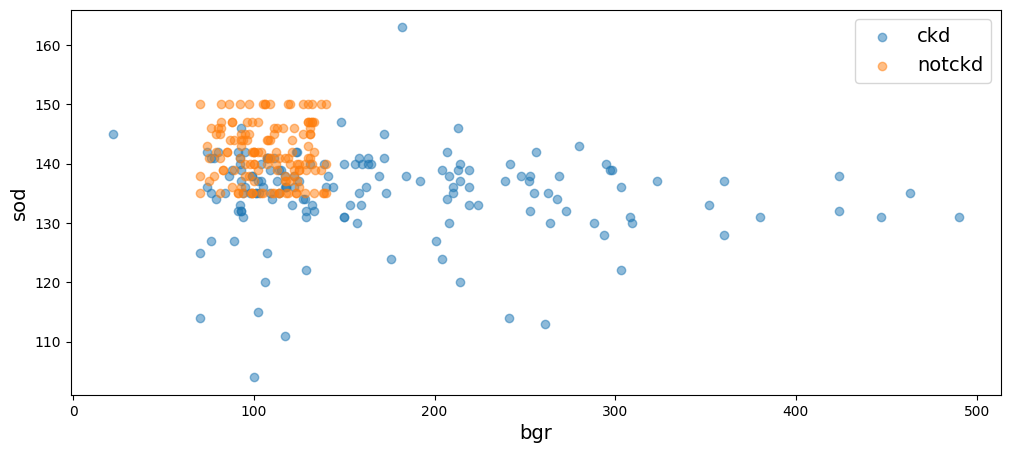

<Figure size 640x480 with 0 Axes>

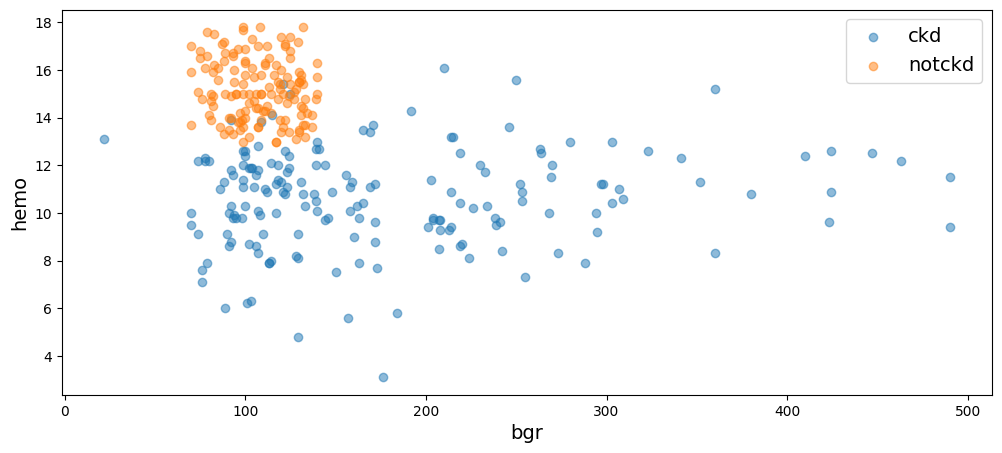

<Figure size 640x480 with 0 Axes>

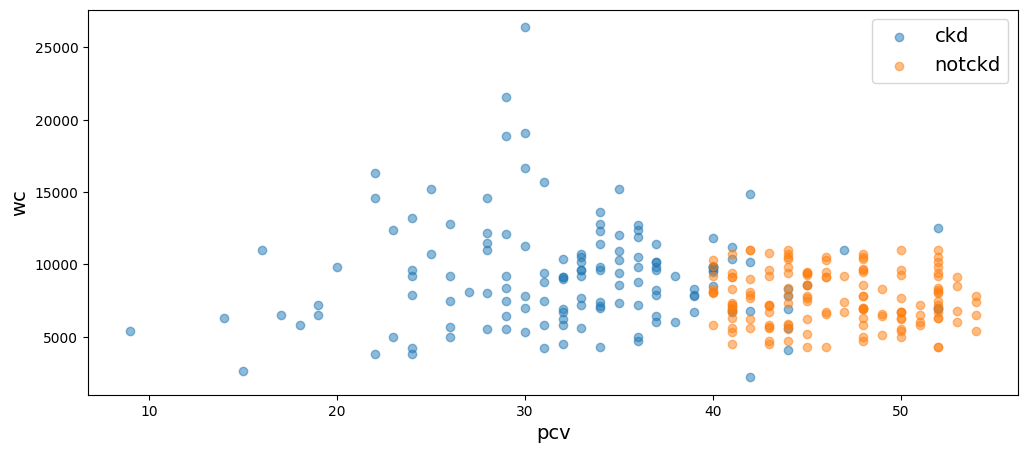

<Figure size 640x480 with 0 Axes>

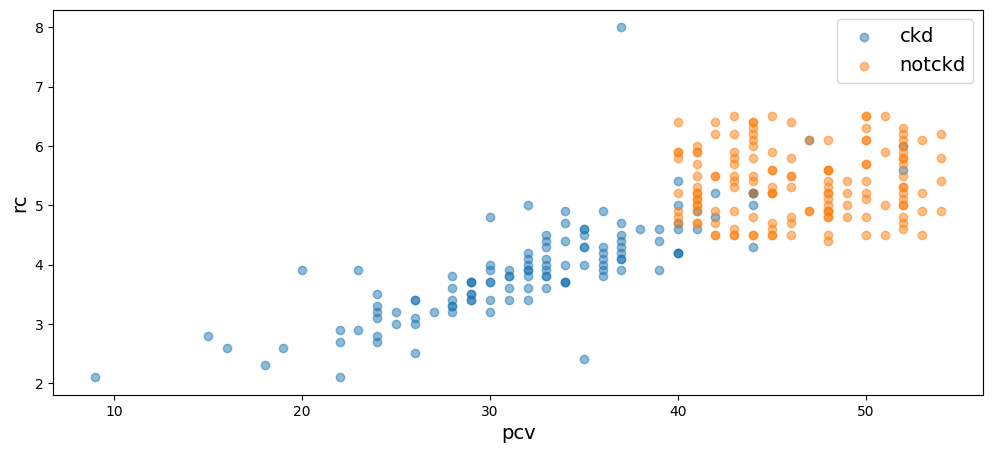

<Figure size 640x480 with 0 Axes>

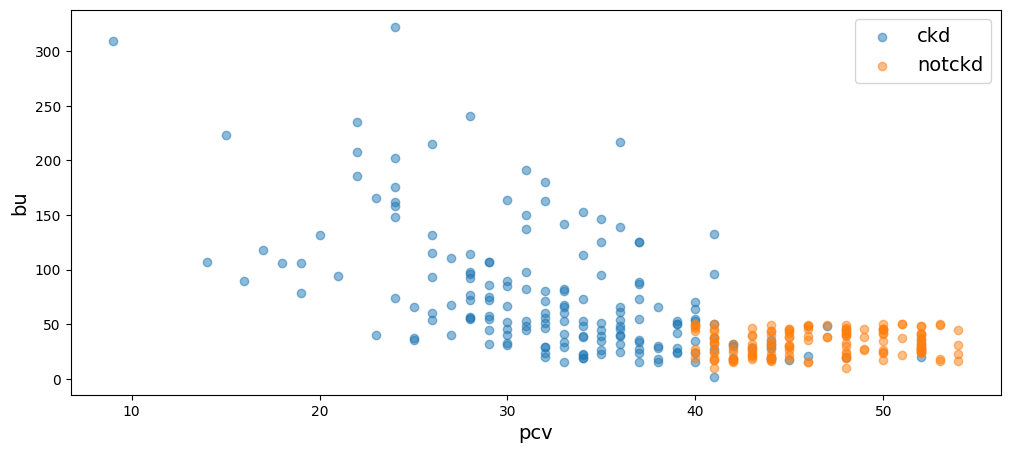

<Figure size 640x480 with 0 Axes>

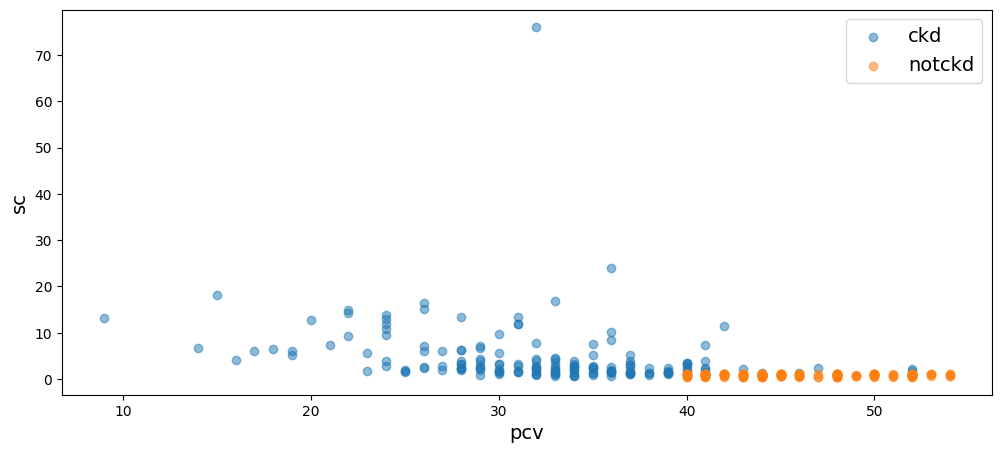

<Figure size 640x480 with 0 Axes>

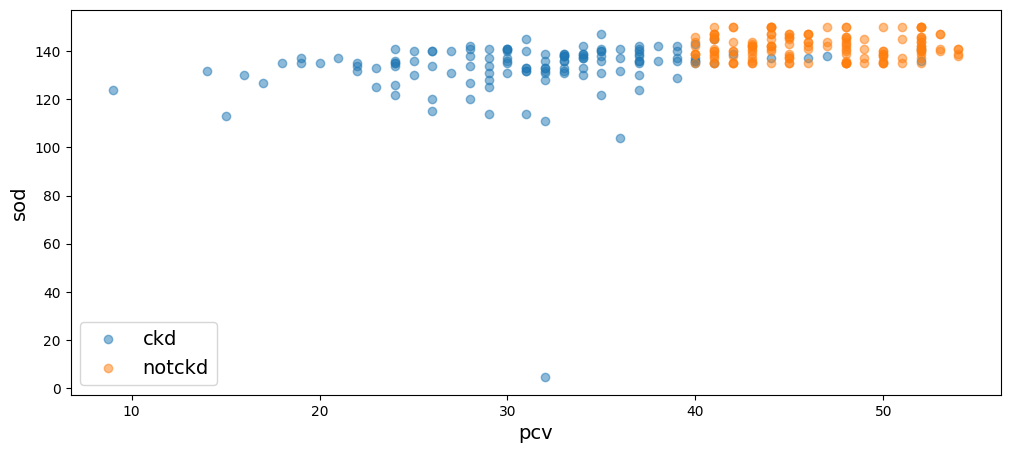

<Figure size 640x480 with 0 Axes>

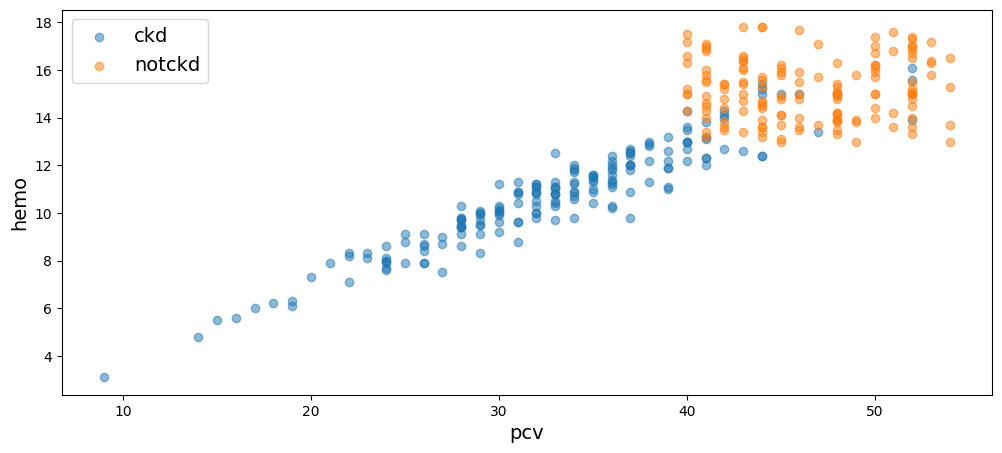

<Figure size 640x480 with 0 Axes>

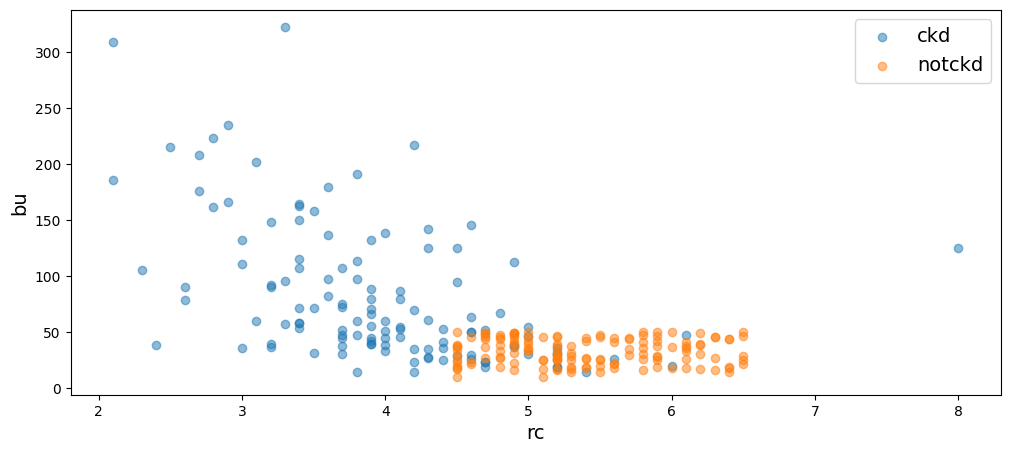

<Figure size 640x480 with 0 Axes>

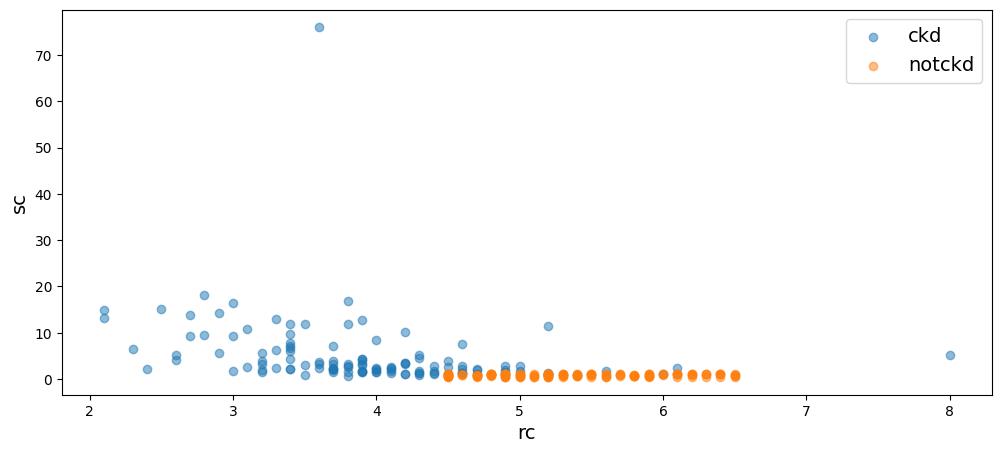

<Figure size 640x480 with 0 Axes>

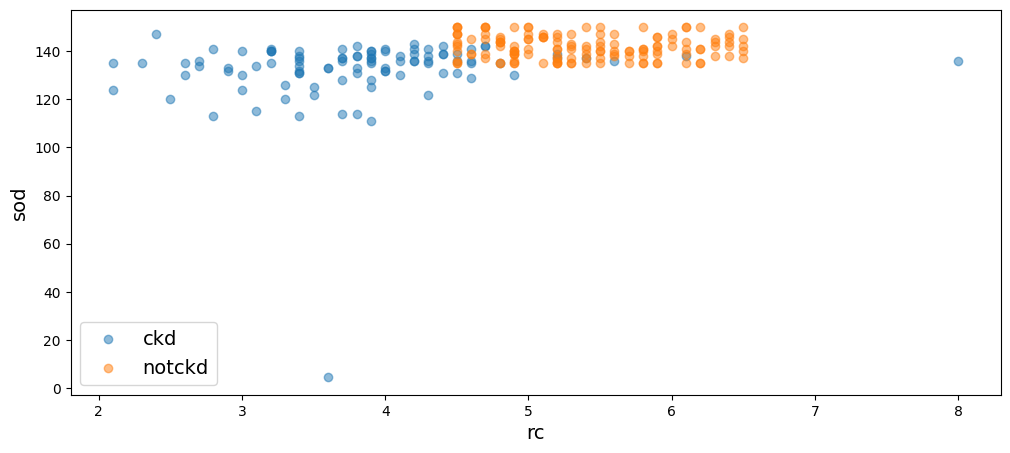

<Figure size 640x480 with 0 Axes>

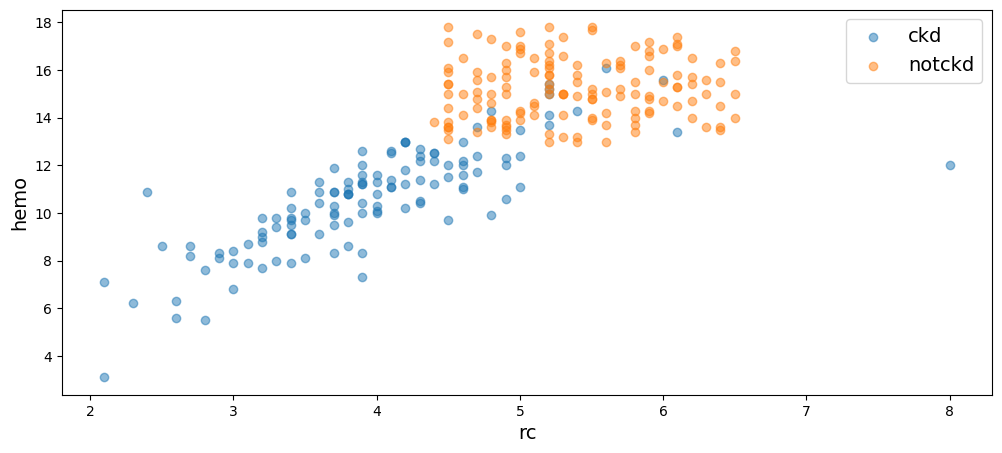

<Figure size 640x480 with 0 Axes>

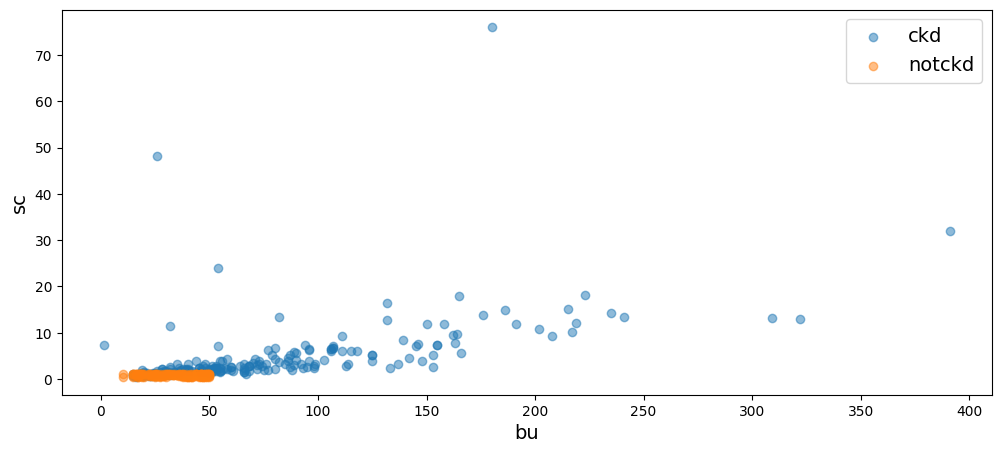

<Figure size 640x480 with 0 Axes>

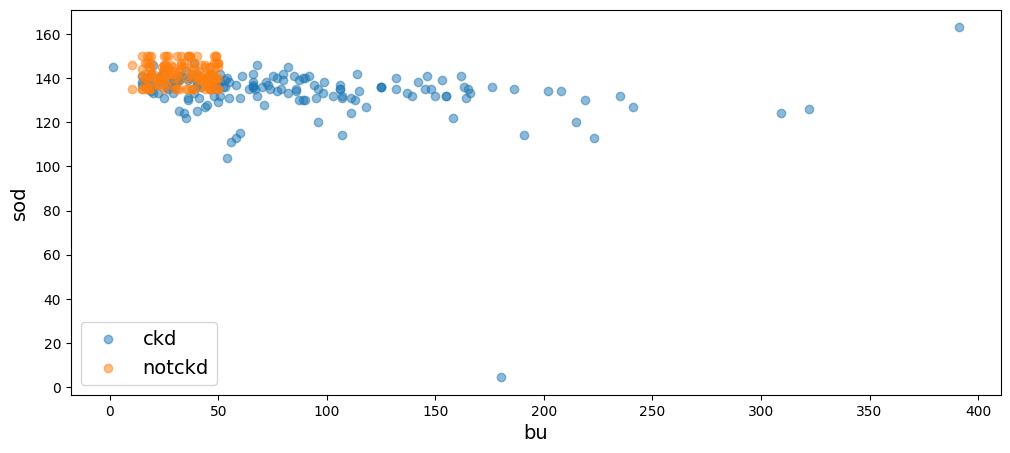

<Figure size 640x480 with 0 Axes>

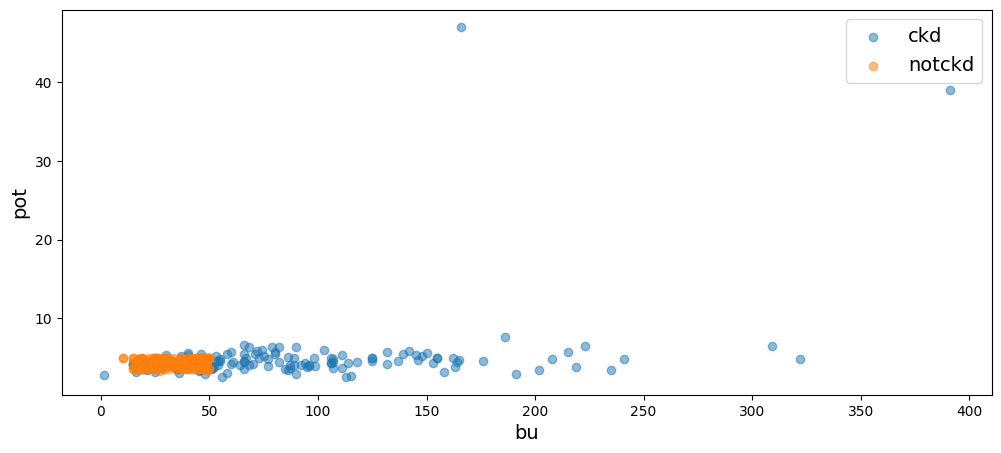

<Figure size 640x480 with 0 Axes>

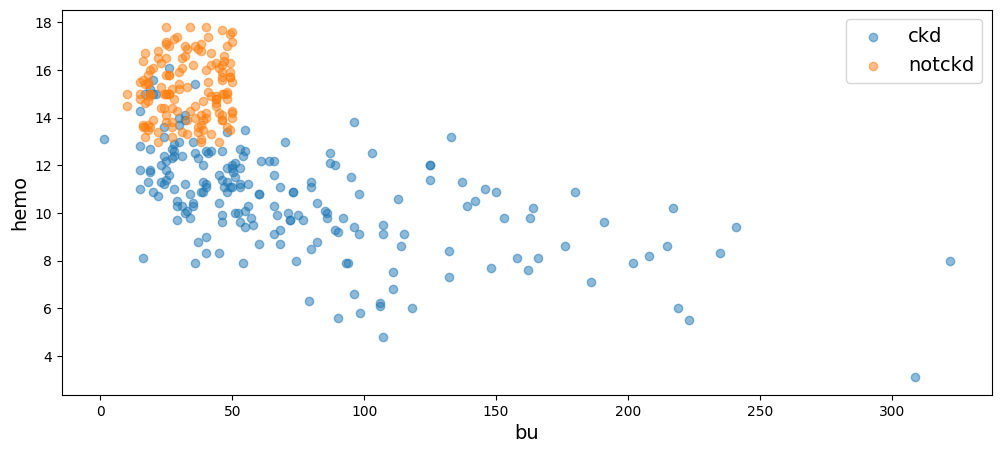

<Figure size 640x480 with 0 Axes>

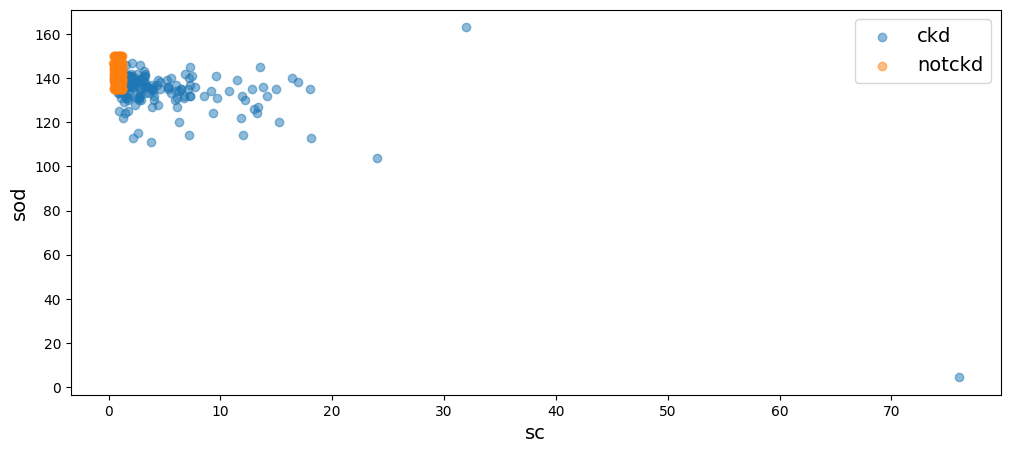

<Figure size 640x480 with 0 Axes>

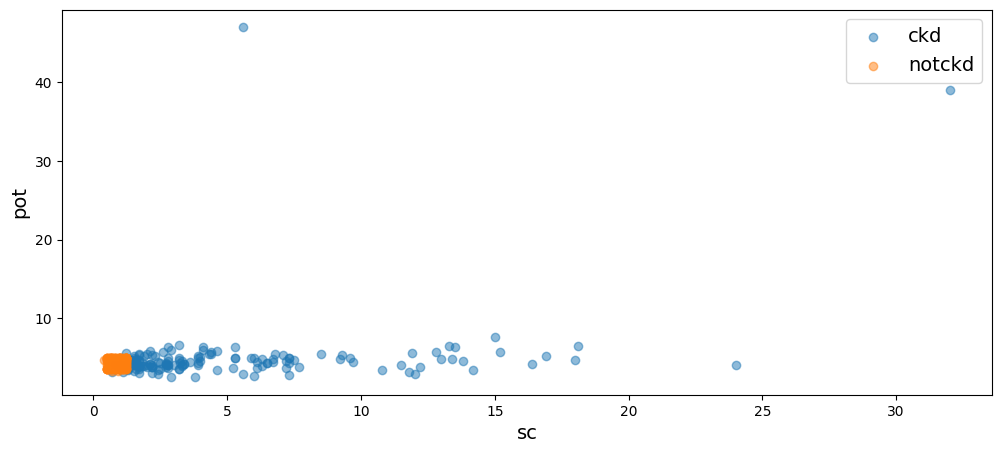

<Figure size 640x480 with 0 Axes>

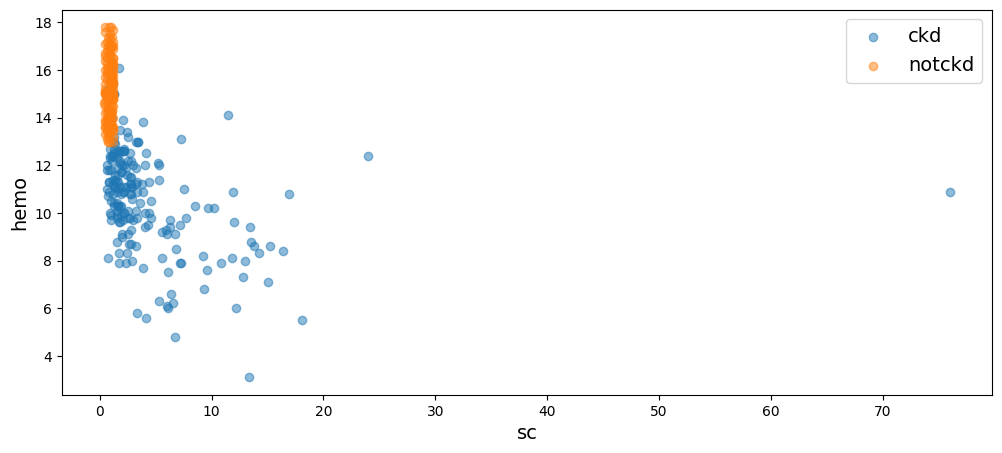

<Figure size 640x480 with 0 Axes>

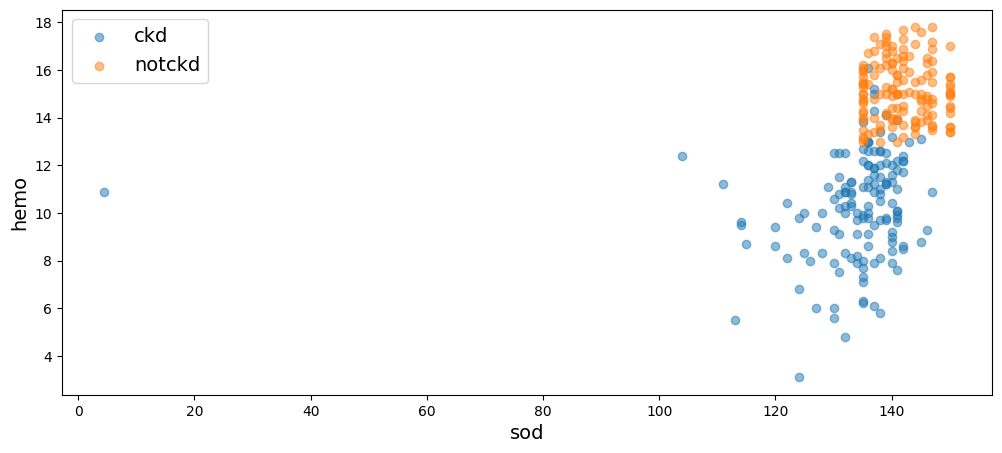

<Figure size 640x480 with 0 Axes>

In [23]:
for col in three_star_columns:
    col1, col2 = col.split(" + ")
    
    df_nona_plot = df[[col1, col2, "classification"]].dropna()
    
    df_nona_plot_ckd = df_nona_plot[df_nona_plot["classification"]=="ckd"]
    df_nona_plot_notckd = df_nona_plot[df_nona_plot["classification"]=="notckd"]
    
    plt.figure(figsize=(12, 5))
    
    plt.scatter(df_nona_plot_ckd[col1], df_nona_plot_ckd[col2], 
                alpha=0.5, label="ckd")
    plt.scatter(df_nona_plot_notckd[col1], df_nona_plot_notckd[col2], 
                alpha=0.5, label="notckd")
    
    plt.xlabel(col1, fontsize=14)
    plt.ylabel(col2, fontsize=14)
    plt.legend(fontsize=14)
    
    plt.show()
    
    plt.savefig("Images/Scatter_"+col+".png")

## Imputation

In [24]:
df_imp = df.copy()

In [25]:
for col in df.columns:
    if pd.api.types.is_numeric_dtype( df[col] ) and col != "id" and col != "num_clf":
        if np.sum(np.isnan(df[col].values)) > 0:
            df[col+"_imp_median"] = df[col].fillna( df[col].median() )

### Column transformation

In [26]:
transf_list_name = ["log1p", "sqrt", "inverse", "square", "exp"]
def inverse(x):
    return 1/x
def square(x):
    return x**2
func_list = [np.log1p, np.sqrt, inverse, square, np.exp]

for col in df.columns:
    if pd.api.types.is_numeric_dtype( df[col] ) and "id" not in col and "num_clf" not in col:
        for ct_i, func in enumerate(func_list):
            x = list(map(func, df[col].dropna().values))
            
            k, pvalue = sc_stats.normaltest( x )
            #print(pvalue)
            if pvalue > pvalue_th:
                print("Variable", col, "is normal with transformation:", transf_list_name[ct_i])
            

Variable bp is normal with transformation: inverse
Variable bp_imp_median is normal with transformation: inverse
Variable pcv_imp_median is normal with transformation: square


## Clasification

In [27]:
col_median_imp = check_end_or_begin_with(df.columns, "median", mode="end")
print("Columns imputed by median:", len(col_median_imp), "which are:", col_median_imp)
col_normal = list()
for col in df.columns:
    if "median" not in col and "id" not in col and "num_clf" not in col:
        if pd.api.types.is_numeric_dtype( df[col] ):
            col_normal.append(col)
print("Columns not imputed:", len(col_normal), "which are:", col_normal)

Columns imputed by median: 14 which are: ['age_imp_median', 'bp_imp_median', 'sg_imp_median', 'al_imp_median', 'su_imp_median', 'bgr_imp_median', 'bu_imp_median', 'sc_imp_median', 'sod_imp_median', 'pot_imp_median', 'hemo_imp_median', 'pcv_imp_median', 'wc_imp_median', 'rc_imp_median']
Columns not imputed: 28 which are: ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'rbc_nan', 'rbc_normal', 'pc_nan', 'pc_normal', 'pcc_notpresent', 'ba_notpresent', 'htn_yes', 'dm_nan', 'dm_yes', 'cad_no', 'appet_nan', 'appet_good', 'pe_no', 'ane_no']


In [39]:
df["target"] = (df["classification"] == "ckd")*1
df.loc[df[df["classification"].isna()].index, "target"] = np.nan

In [41]:
dataset_name = ["Normal", "Median_imputed"]
columns_to_model = [col_normal, col_median_imp]
target_list = ["target"]

models_list = [
    LogisticRegression(n_jobs=-1)
]
name_models_list = [
    "LGR"
]
grid_search_list = [{
    'penalty' : ['l2', "l1"],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear', "saga"]
}]

In [45]:
folds_th = 10
n_rep_th = 4

rskf = RepeatedStratifiedKFold(n_splits=folds_th, 
                              n_repeats=n_rep_th, 
                              random_state=seed_th)
for tar in target_list:
    print("Studying target:", tar)
    
    for ct_i, col in enumerate(columns_to_model):
        
        print("Using dataset", dataset_name[ct_i])
        df_nona_model = df[[tar]+col].dropna()
        print("Shape of the dataset", df_nona_model.shape)
        
        X, Y = df_nona_model[col], df_nona_model[tar]
            
        for ct_m, model in enumerate(models_list):
            print("Using model", name_models_list[ct_m])
            
            sfs1 = SFS(model, 
                       k_features=10, 
                       forward=False, 
                       floating=False, 
                       verbose=0, 
                       cv=rskf, 
                       n_jobs=-1,
                       scoring="accuracy")

            X_new = sfs1.fit_transform(X, Y)
            
            metrics_dict = {
                "Accuracy": [],
                "Kappa": [],
                "AUC": []
            }
            acc_list, kappa_list, auc_list = [], [], []
            for train_idx, test_idx in rskf.split(X_new, Y):
                
                scaler = MinMaxScaler(feature_range = (0,1))
                
                xtrain, ytrain = X_new[train_idx], Y.values[train_idx]
                xtrain_minmax = scaler.fit_transform(xtrain)
                
                xtest, ytest = X_new[test_idx], Y.values[test_idx]
                xtest_minmax = scaler.fit_transform(xtest)

                if grid_search_list[ct_m] is not None:
                    clf = GridSearchCV(model, param_grid=grid_search_list[ct_m], n_jobs=-1)
                else:
                    clf = model
                
                clf.fit(xtrain_minmax, ytrain)
                ypred = clf.predict(xtest_minmax)
                
                acc = accuracy_score(ytest, ypred)
                metrics_dict["Accuracy"].append(acc)
                
                kappa = cohen_kappa_score(ytest, ypred)
                metrics_dict["Kappa"].append(kappa)
                
                auc_value = roc_auc_score(ytest, ypred)
                metrics_dict["AUC"].append(auc_value)
            
            print("Accuracy = ", np.round(np.nanmean(metrics_dict["Accuracy"]),2), 
                  "+/-", np.round(np.nanstd(metrics_dict["Accuracy"]),2))
            print("Kappa = ", np.round(np.nanmean(metrics_dict["Kappa"]),2), 
                  "+/-", np.round(np.nanstd(metrics_dict["Kappa"]),2))
            print("AUC = ", np.round(np.nanmean(metrics_dict["AUC"]),2), 
                  "+/-", np.round(np.nanstd(metrics_dict["AUC"]),2))
            
            print("*"*50)

Studying target: target
Using dataset Normal
Shape of the dataset (201, 29)
Using model LGR
Accuracy =  0.99 +/- 0.02
Kappa =  0.99 +/- 0.03
AUC =  1.0 +/- 0.01
**************************************************
Using dataset Median_imputed
Shape of the dataset (398, 15)
Using model LGR
Accuracy =  0.86 +/- 0.1
Kappa =  0.68 +/- 0.26
AUC =  0.82 +/- 0.13
**************************************************


In [47]:
df.to_csv("Data/ProcessedData.csv", index=False)

## Regression